<h1 style="font-size: 48px;">A CLIMAX-TUTORIAL</h1>

In [1]:
PATH = "/mnt/shared/users/wessim.omezzine/"

In [3]:
import numpy as np
import xarray as xr
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

import sys
sys.path.append(PATH + 'ClimaX')
sys.path.append(PATH + 'ClimaX/src')



In [11]:
data = np.load("Data/CHIRPS_MODIS/data_npz/train/2002_0.npz")
print(vars(data))
data["r1h_dekad"].shape

{'_files': ['rfh.npy', 'r1h_dekad.npy', 'r2h_dekad.npy', 'r3h_dekad.npy', 'lst_5.npy', 'ndvi_5.npy'], 'files': ['rfh', 'r1h_dekad', 'r2h_dekad', 'r3h_dekad', 'lst_5', 'ndvi_5'], 'allow_pickle': False, 'max_header_size': 10000, 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True}, 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='Data/CHIRPS_MODIS/data_npz/train/2002_0.npz'> mode='r'>, 'f': <numpy.lib.npyio.BagObj object at 0x7fd56b04bb80>, 'fid': <_io.BufferedReader name='Data/CHIRPS_MODIS/data_npz/train/2002_0.npz'>}


(6, 1, 73, 138)

# Dependencies and requirements

Available in `ClimaX/docker/environment.yml`. ClimaX uses specific old versions of some packages

# Data preparation and Preprocessing

## ERA5 Data 

For memory issues, we choose only 3 varaibales of ERA5 data to finetune our pretrained model. We pre-process them with the script `ClimaX/src/data_preprocessing/nc2np_equally_era5.py`. 

REMARK: Climax scripts can only be run as a script as we give the inputs as a click.option example: `! python script.py -input_1="path/to/dir"`

In [ ]:
\5.625deg_npz
    |-- 10m_u_component_of_wind 
        |--10m_u_component_of_wind_1970.nc
        |--10m_u_component_of_wind_1971.nc
        |--10m_u_component_of_wind_1972.nc
        |--10m_u_component_of_wind_1973.nc
    |-- 2m_temperature
    |-- constants.nc


In [ ]:
! source activate hdc && python src/data_preprocessing/nc2np_equally_era5.py -v '10m_u_component_of_wind' -v '2m_temperature' --root_dir /mnt/shared/users/wessim.omezzine/ClimaX/Data/ERA5/5.625deg --save_dir /mnt/shared/users/wessim.omezzine/ClimaX/Data/ERA5/5.625deg_npz --start_train_year 1979 --start_val_year 2016 --start_test_year 2017 --end_year 2019 --num_shards 8

This script will output the preprocessed data directory will look like the following:

In [ ]:
5.625deg_npz
   |-- train
        |--1970_0.nc
        |--1971_0.nc
        |--1972_0.nc
   |-- val
   |-- test
   |-- normalize_mean.npz
   |-- normalize_std.npz
   |-- lat.npy
   |-- lon.npy

We can check the shape of the prepocessed files we will take 1979_1.nc

In [ ]:
data = np.load(PATH+ "ClimaX/Data/ERA5/5.625deg_npz/train/1979_1.npz")
for key in data.keys():
    array = data[key]
    print(f"Array '{key}' shape: {array.shape}")

# FineTuning the model for golbal forecast  with ERA5

Finetuning requires pretrained models. Climax is pretrained on CMIP6. The script uses many inputs. Some of these inputs are given as clickoption in the call of the script and other inputs are given in `ClimaX/configs/global_forecast_climax.yaml`

In [ ]:
! pwd

In [ ]:
! source activate /envs/hdc &&  python src/climax/global_forecast/train.py --config configs/global_forecast_climax.yaml  --trainer.strategy=ddp --trainer.devices=8     --trainer.max_epochs=2     --data.root_dir=Data/ERA5/5.625deg_npz     --data.predict_range=72 --data.out_variables=['2m_temperature']     --data.batch_size=16     --model.pretrained_path="https://huggingface.co/tungnd/climax/resolve/main/5.625deg.ckpt"     --model.lr=5e-7 --model.beta_1="0.9" --model.beta_2="0.99"     --model.weight_decay=1e-5 --data.variables=['10m_u_component_of_wind','2m_temperature']  --model.net.depth=2

### We can also create a function to visualize the forecast

In [ ]:
import torch 
from climax.global_forecast.datamodule import GlobalForecastDataModule
from climax.global_forecast.module import GlobalForecastModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX

In [ ]:
TASK_TO_RANGE = {
    '3days': 72,
    '5days': 120,
    '7days': 168
}

var = 'z_500'
task = '3days'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
          "2m_temperature",
          "10m_u_component_of_wind",
        ]
      ,'img_size': [32, 64]
      ,'patch_size': 2
      ,'embed_dim': 4 #1024
      ,'depth': 2
      ,'decoder_depth': 2
      ,'num_heads': 2
      ,'mlp_ratio': 4
      ,'drop_path': 0.1
      ,'drop_rate': 0.1
    
}
net = ClimaX(**net_args)

In [ ]:
model = GlobalForecastModule(net = net, pretrained_path = "")

In [ ]:
datamodule = GlobalForecastDataModule(
    root_dir=f'/mnt/shared/users/wessim.omezzine/ClimaX/Data/ERA5/5.625deg_npz',
    variables=[
        "2m_temperature",
        "10m_u_component_of_wind",
    ],
    out_variables=["2m_temperature"],
 
    predict_range=pred_range,
    hrs_each_step=1,
    buffer_size=2000,
    batch_size=1
)


normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)


datamodule.setup()


In [ ]:
def visualize_forecast(model_module, data_module, pred_task, var_name, save_path = None):
    # model_module.eval()
    model_module.cuda()
    
    dataloader = data_module.test_dataloader()
  
    x, y, lead_times, in_vars, out_vars = next(iter(dataloader))
    x = x.cuda()
    y = y.cuda()
    lead_times = lead_times.cuda()

    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, None, model_module.lat)
    
    var_id = model_module.net.get_channel_ids(out_vars)
    x = x[:, :, var_id]

    inv_normalize = model_module.denormalization
    init_condition, gt = inv_normalize(x), inv_normalize(y)
    pred = inv_normalize(pred)
    bias = pred - gt
    
    index = 0

    for i, tensor in enumerate([init_condition, gt, pred, bias]):
        ax = axes[index][i]
        im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off

    axes[index][0].text(-10, 64, var_name, fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"Initial condition", fontsize='xx-large')
    axes[index][1].set_title(f"Ground truth", fontsize='xx-large')
    axes[index][2].set_title(f"{pred_task} Prediction", fontsize='xx-large')
    axes[index][3].set_title(f"Bias", fontsize='xx-large')

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0.025, hspace=0.025,)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
        
    del x
    del y
    del pred

visualize_forecast(model, datamodule, '3-day', "2m_temperature", 'forecast_t2m_3days.png')

# Let's try this on our data 

## get data 

In [3]:
! pip install numpy==1.24

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 21.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs1cdec8c436627bfa00000003'



In [110]:
import sys 
sys.path.append("/mnt/shared/users/wessim.omezzine/hip-analysis")
from hip.analysis.aoi import AnalysisArea
from hip.analysis.data._datasources import DATASOURCE_CONFIGS
import os
import dask
from dask.distributed import Client, progress
import rioxarray as rxr
import glob
import xarray as xr
import tqdm
import numpy as np

# Create a dask client to distribute (speed up) the coputation

# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
    jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
    if jup_prefix is not None:
        jup_prefix = jup_prefix.rstrip('/')
        dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

client = Client()
client

GDAL_DATA                    = /envs/user/fix_hdc/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:44335
INFO:distributed.scheduler:  dashboard at:  /user/wessim.omezzine/proxy/8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39415'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42277'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46783'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36819'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43295', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43295
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:58366
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33457', na

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/wessim.omezzine/proxy/8787/status,
Dashboard: /user/wessim.omezzine/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44335,Workers: 4
Dashboard: /user/wessim.omezzine/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.20 GiB
Comm: tcp://127.0.0.1:44871,Total threads: 1
Dashboard: /user/wessim.omezzine/proxy/41073/status,Memory: 3.80 GiB
Nanny: tcp://127.0.0.1:39415,


In [111]:
bbox = (26.542969,13.239945,33.398438,16.804541) #sudan

area = AnalysisArea(
    bbox=bbox,
    datetime_range="2002-06-01/2023-06-30"
)


In [112]:
ndvi_5 = area.get_dataset(["MODIS","NDVI_smoothed_5KM"])[:,:32,:64]
lst_5 = area.get_dataset(["MODIS","LST_smoothed_5KM"])[:,:32,:64]
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])[:,:32,:64]
r1h_dekad = area.get_dataset(["CHIRPS","r1h_dekad"])[:,:32,:64]
r2h_dekad = area.get_dataset(["CHIRPS","r2h_dekad"])[:,:32,:64]
r3h_dekad = area.get_dataset(["CHIRPS","r3h_dekad"])[:,:32,:64]

rfh = rfh.sel(time=lst_5.time.values)    #Align the time grid

In [4]:
ndvi_5

<xarray.DataArray 'band' (time: 756, latitude: 32, longitude: 64)>
dask.array<getitem, shape=(756, 32, 64), dtype=float64, chunksize=(1, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 16.83 16.78 16.73 ... 15.38 15.33 15.28
  * longitude    (longitude) float64 26.52 26.57 26.62 ... 29.57 29.62 29.67
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2002-07-01 2002-07-11 ... 2023-06-21
Attributes:
    nodata:   nan

In [5]:
ndvi_5.to_netcdf("Data/forecasting/data/ndvi_5.nc")
lst_5.to_netcdf("Data/forecasting/data/lst_5.nc")
rfh.to_netcdf("Data/forecasting/data/rfh.nc") 
r1h_dekad.to_netcdf("Data/forecasting/data/r1h_dekad.nc") 
r2h_dekad.to_netcdf("Data/forecasting/data/r2h_dekad.nc") 
r3h_dekad.to_netcdf("Data/forecasting/data/r3h_dekad.nc") 

INFO:distributed.scheduler:Receive client connection: Client-worker-23f47d00-35df-11ee-81c9-0aa34f1571d3
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38250
INFO:distributed.scheduler:Receive client connection: Client-worker-23fa0fe2-35df-11ee-81c7-0aa34f1571d3
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38266


In [6]:
xr.load_dataset("Data/forecasting/data/ndvi_5.nc")

<xarray.Dataset>
Dimensions:      (latitude: 32, longitude: 64, time: 756)
Coordinates:
  * latitude     (latitude) float64 16.83 16.78 16.73 ... 15.38 15.33 15.28
  * longitude    (longitude) float64 26.52 26.57 26.62 ... 29.57 29.62 29.67
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2002-07-01 2002-07-11 ... 2023-06-21
Data variables:
    band         (time, latitude, longitude) float64 0.1145 0.1203 ... 0.1237

In [31]:
! python src/data_preprocessing/nc2np_equally_chirps.py

GDAL_DATA                    = /envs/user/fix_hdc/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.10it/s]


In [74]:
PATH = "/mnt/shared/users/wessim.omezzine/"
data = np.load(PATH+ "ClimaX/Data/forecasting/data_npz/train/2002_0.npz")



# Crop each variable in the data to the new shape
for key in data.keys():
    array = data[key]
    print(f"Array '{key}' shape: {array.shape}")

Array 'rfh' shape: (12, 1, 32, 64)
Array 'r1h_dekad' shape: (12, 1, 32, 64)
Array 'r2h_dekad' shape: (12, 1, 32, 64)
Array 'r3h_dekad' shape: (12, 1, 32, 64)
Array 'lst_5' shape: (12, 1, 32, 64)
Array 'ndvi_5' shape: (12, 1, 32, 64)


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Height')

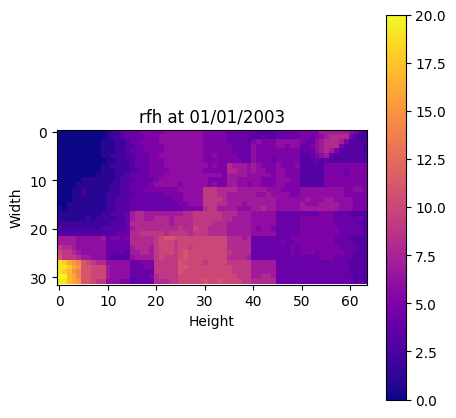

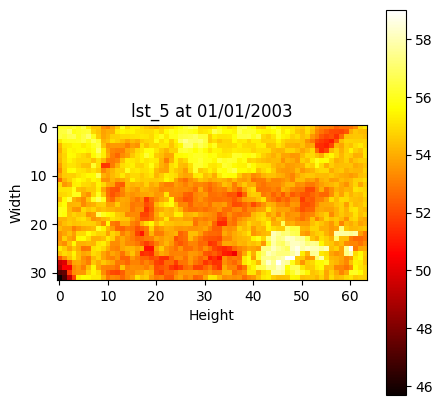

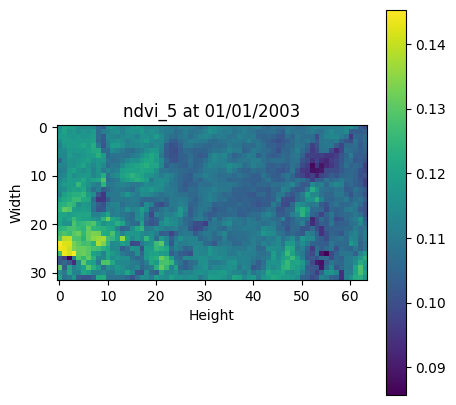

In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(data['rfh'][0,0,:,:],cmap='plasma', interpolation='nearest')
plt.title('rfh at 01/01/2003')
plt.colorbar()
plt.ylabel('Width')
plt.xlabel('Height')

plt.figure(figsize=(5, 5))
plt.imshow(data['lst_5'][0,0,:,:], cmap='hot', interpolation='nearest')
plt.title('lst_5 at 01/01/2003')
plt.colorbar()
plt.ylabel('Width')
plt.xlabel('Height')

plt.figure(figsize=(5, 5))
plt.imshow(data['ndvi_5'][0,0,:,:], cmap='viridis', interpolation='nearest')
plt.title('ndvi_5 at 01/01/2003')
plt.colorbar()
plt.ylabel('Width')
plt.xlabel('Height')


# Finetune 

In [ ]:
! source activate hdc && \
 python /mnt/shared/users/wessim.omezzine/ClimaX/src/climax/global_forecast/train.py --config /mnt/shared/users/wessim.omezzine/ClimaX/configs/global_forecast_climax_CHIRPS_MODIS.yaml --model.pretrained_path="https://huggingface.co/tungnd/climax/resolve/main/5.625deg.ckpt" \
--model.net.img_size=[500,340]

# Visualize Results

In [115]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F

from climax.global_forecast.datamodule import GlobalForecastDataModule
from climax.global_forecast.module import GlobalForecastModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX


TASK_TO_RANGE = {
    '0 days' : 0,
    '10 days' : 1,
    '40 days': 4,
    '50 days': 5,
    '60 days': 6,
    '20 days': 2,
    '30 days': 3,
    '90 days': 9,
}

## Utils

In [127]:
def plot_pred(tensors, var_name, pred_task):
    index = 0
    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    image1_np = tensors[0].detach().squeeze().cpu().numpy()
    image2_np = tensors[1].detach().squeeze().cpu().numpy()
    image3_np = tensors[2].detach().squeeze().cpu().numpy()
    vmin = min(np.min(image1_np), np.min(image2_np), np.min(image3_np))
    vmax = max(np.max(image1_np), np.max(image2_np), np.max(image3_np))
    
    print(vmin, vmax)

    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        if i<3 : 
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy(),vmin=vmin, vmax=vmax)

        else :
            data = tensor.detach().squeeze().cpu().numpy()
            im = ax.imshow(data, vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off
        
        
    
    axes[index][0].text(-10, 64, var_name, fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"Initial condition", fontsize='xx-large')
    axes[index][1].set_title(f"Ground truth", fontsize='xx-large')
    axes[index][2].set_title(f"{pred_task} dekad Prediction", fontsize='xx-large')
    axes[index][3].set_title(f"Bias", fontsize='xx-large')

    plt.show()
    

def plot_inputs(tensors, var_name, pred_task):
    index = 0
    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off
        
        

    axes[index][0].text(-10, 64, "Inputs", fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"lst", fontsize='xx-large')
    axes[index][1].set_title(f"rfh", fontsize='xx-large')
    # axes[index][1].set_title(f"r1h_dekad", fontsize='xx-large')
    # axes[index][1].set_title(f"r2h_dekad", fontsize='xx-large')
    # axes[index][1].set_title(f"r3h_dekad", fontsize='xx-large')
    axes[index][2].set_title(f"ndvi", fontsize='xx-large')
   

    plt.show()
    
    
def preprocess (pred_task,model_module, data_module,mean_norm, std_norm, var_id,data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz", verbose=True, nb_var=3):
    '''Normalize data to do the forward'''
    
    data  = np.load(data_path)
    
    rfh = data['rfh']
    lst_5 = data['lst_5']
    ndvi_5 = data['ndvi_5']
    
    print("shape", rfh.shape)
    
    rfh_tensor = torch.from_numpy(rfh).type(torch.float32)
    lst_5_tensor = torch.from_numpy(lst_5).type(torch.float32)
    ndvi_5_tensor = torch.from_numpy(ndvi_5).type(torch.float32)
    if nb_var ==3:
        data_one_dekad =  torch.cat((lst_5_tensor,rfh_tensor ,ndvi_5_tensor), dim=1)
    else : 
        data_one_dekad =  torch.cat((lst_5_tensor,rfh_tensor,r1h_dekad_tensor, r2h_dekad_tensor, r3h_dekad_tensor ,ndvi_5_tensor), dim=1)
    
    print(data_one_dekad.shape)
    x_input = data_one_dekad[0].unsqueeze(0)  
    y_input =  data_one_dekad[pred_task-1,var_id].unsqueeze(0).unsqueeze(0)
    
    mean = torch.mean(x_input, dim=(0, 2, 3))
    std = torch.std(x_input, dim=(0, 2, 3))
    # Convert the mean and std tensors to lists
    mean_list = mean.tolist()
    std_list = std.tolist()
    # Define the transformation
    transform = transforms.Compose([
        transforms.Normalize(mean_list, std_list)
    ])
    norm_x = transform(x_input)
    
    mean = torch.mean(y_input, dim=(0, 2, 3))
    std = torch.std(y_input, dim=(0, 2, 3))
    # Convert the mean and std tensors to lists
    mean_list = mean.tolist()
    std_list = std.tolist()
    # Define the transformation
    transform = transforms.Compose([
        transforms.Normalize(mean_list, std_list)
    ])
    norm_y = transform(y_input)

    
    if verbose:
        print("Input")
        tensors = [x_input[:,0], x_input[:,1], x_input[:,2]]
        plot(tensors, var_name="", pred_task="", inp="inputs")
        
        print("Normalized")
        tensors = [norm_x[:,0], norm_x[:,1], norm_x[:,2]]
        plot(tensors, var_name="", pred_task="", inp="inputs")
        
        print("Y Normalized")
        tensors = [norm_y[:,0]]
        plot(tensors, var_name="", pred_task="", inp="inputs")
    
    return x_input, y_input, norm_x, norm_y
    
    
    


## Regional Forecast 

In [131]:
def visualize_forecast(model_module, data_module,mean_norm, std_norm, pred_task, var_name, var_id,data_path=False, save_path = None):
    model_module.eval()
    model_module.cuda()

    model_module.eval()
    model_module.cuda()

    dataloader = data_module.test_dataloader()
    dataloader_iterator = iter(dataloader)
    
    desired_batch_index = 17

    for batch_idx, batch_data in enumerate(dataloader, 1):
        if batch_idx == desired_batch_index:
            # Process the nth batch (e.g., 10th batch)
            print("Got the {}th batch!".format(batch_idx))
            x, y, lead_times, in_vars, out_vars = batch_data
           
            
#     for _ in range(9): 
#         x, y, lead_times, in_vars, out_vars = next(dataloader_iterator)
        
 
    lead_times = lead_times.cuda()
            
    if data_path!=None:
        x_input, y_input, norm_x, norm_y = preprocess (pred_task,model_module, data_module,mean_norm, std_norm,var_id,data_path, verbose=False)
        x = norm_x
        y = norm_y
    
    
    x = x.cuda()
    y = y.cuda()
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, None, model_module.lat)
    
    inv_normalize = model_module.denormalization

    if data_path!=None:
        tensors = [x_input[:,0],x_input[:,1], x_input[:,2]]
        
    else:
        tensors = [inv_normalize(x[:,0]), inv_normalize(x[:,1]), inv_normalize(x[:,2])]
    plot_inputs(tensors, var_name, pred_task)
    
    
    x = x[:, var_id,:]
    init_condition, gt = inv_normalize(x), inv_normalize(y)
    pred = inv_normalize(pred)
    bias = pred - gt
    tensors = [init_condition, gt, pred, bias]
    plot_pred(tensors, var_name, pred_task)
        
    del x
    del y
    del pred 
    return gt

### Forecast on 20 days

#### LST

In [21]:
task = "30 days"
var = 'ndvi_5'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': ['lst_5','rfh', 'ndvi_5','r1h_dekad','r2h_dekad','r3h_dekad']
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 8,
    "decoder_depth": 2,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_032.ckpt')
datamodule = GlobalForecastDataModule(root_dir=f'Data/forecasting/data_npz',
    variables=[
      'lst_5','rfh','ndvi_5'],
    out_variables=[var],
    predict_range=3,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_032.ckpt
<All keys matched successfully>


In [22]:
normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

In [23]:
datamodule.setup()

**We give as input the file <span style="color: blue;">Data/CHIRPS_MODIS/data_npz/test/2022_0.npz </span>**

3


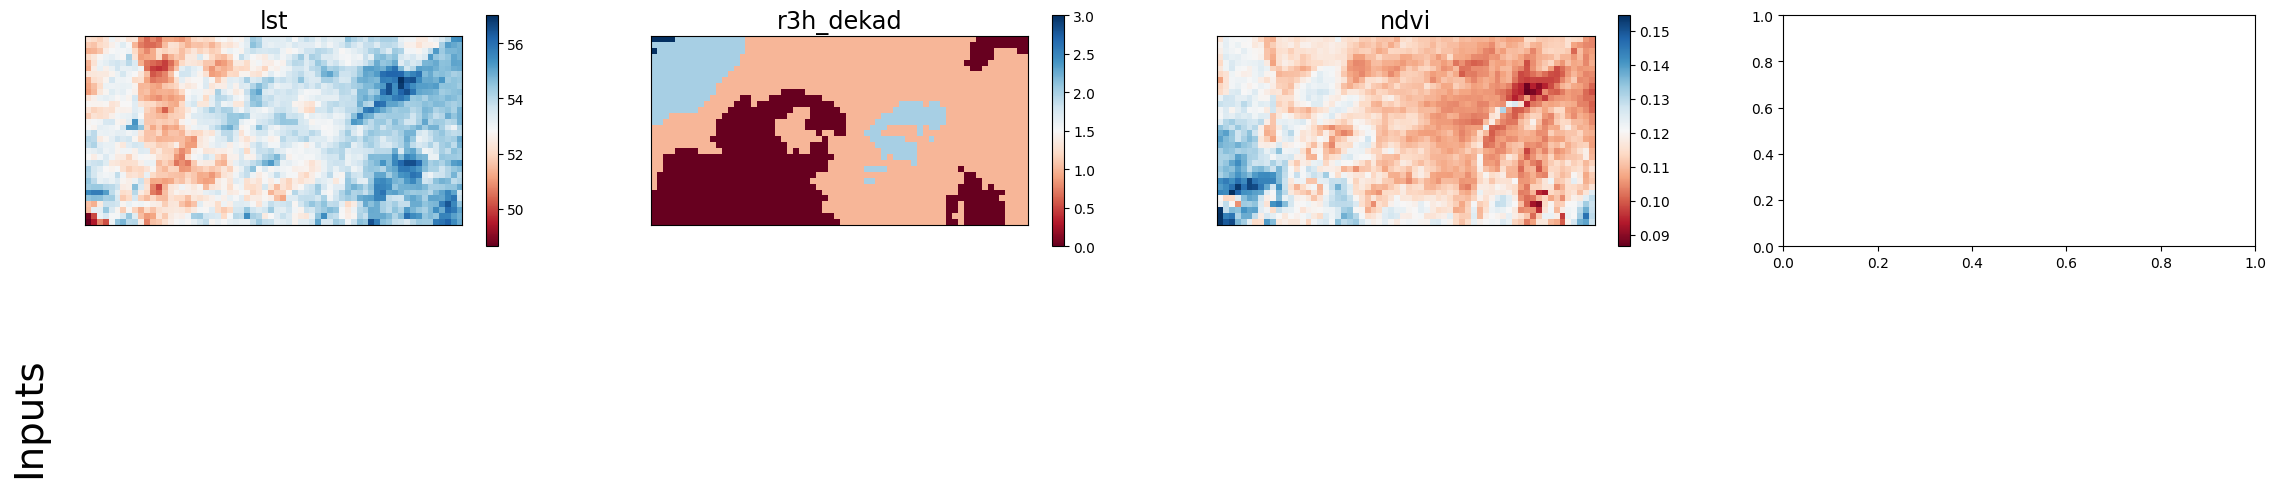

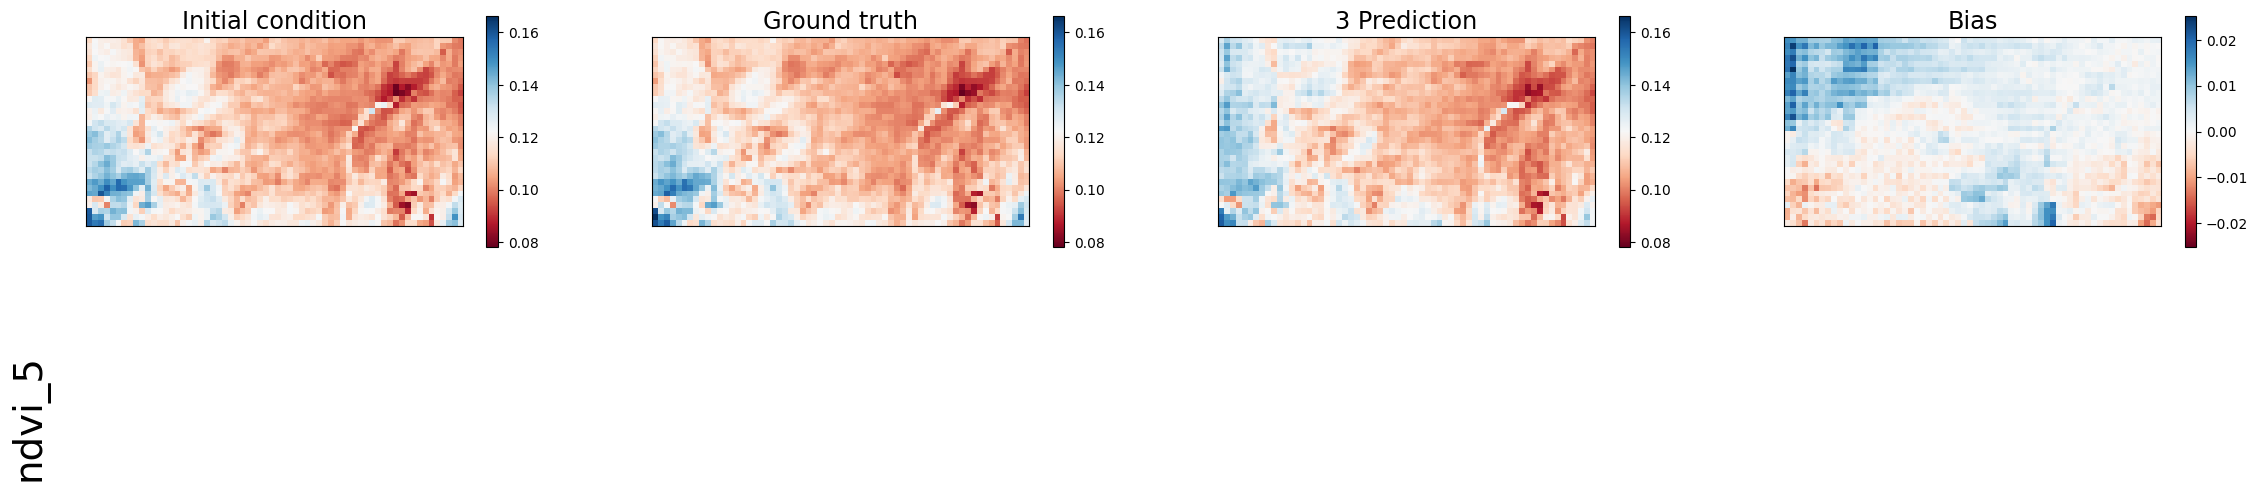

In [47]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 2, data_path="Data/forecasting/data_npz/test/2021_1.npz")

**We give as input a random batch**

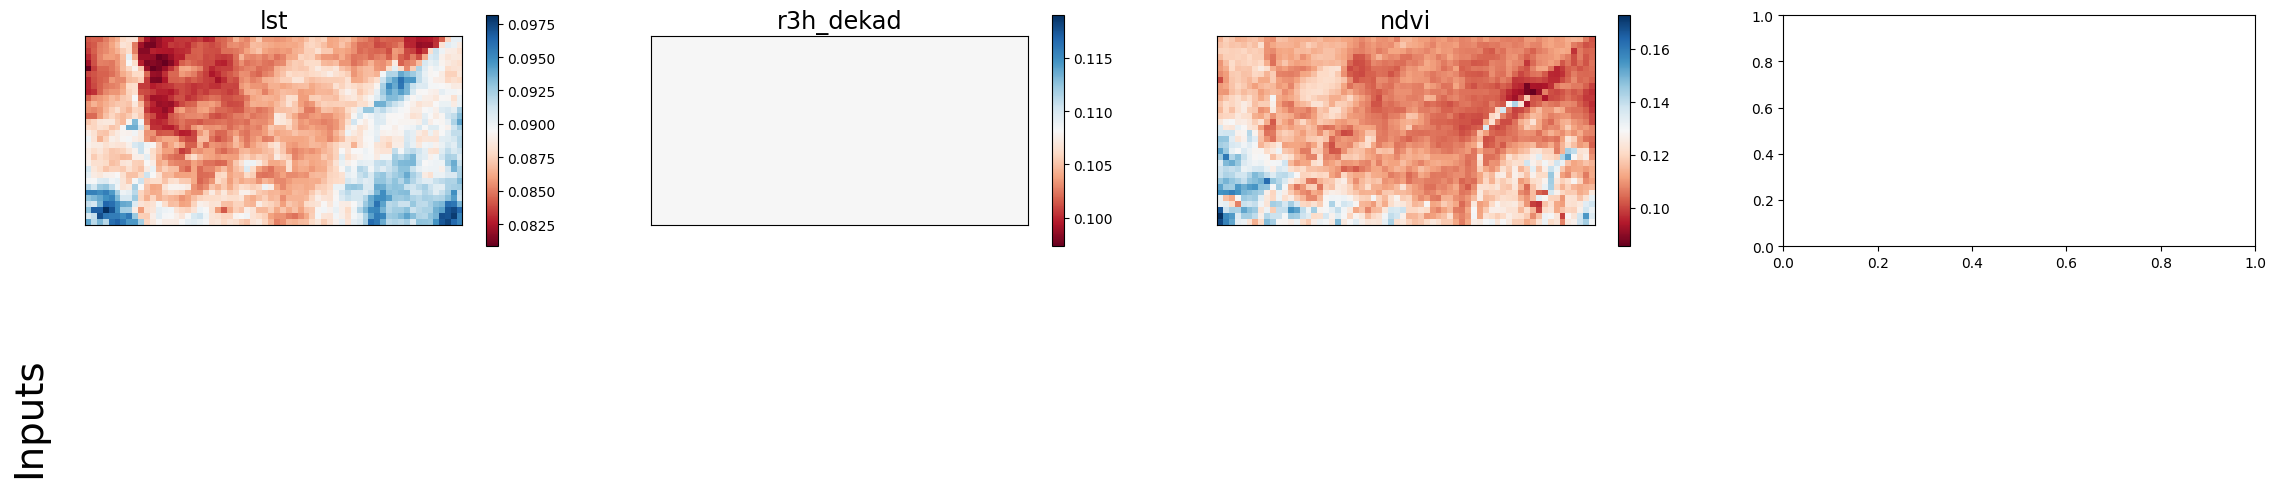

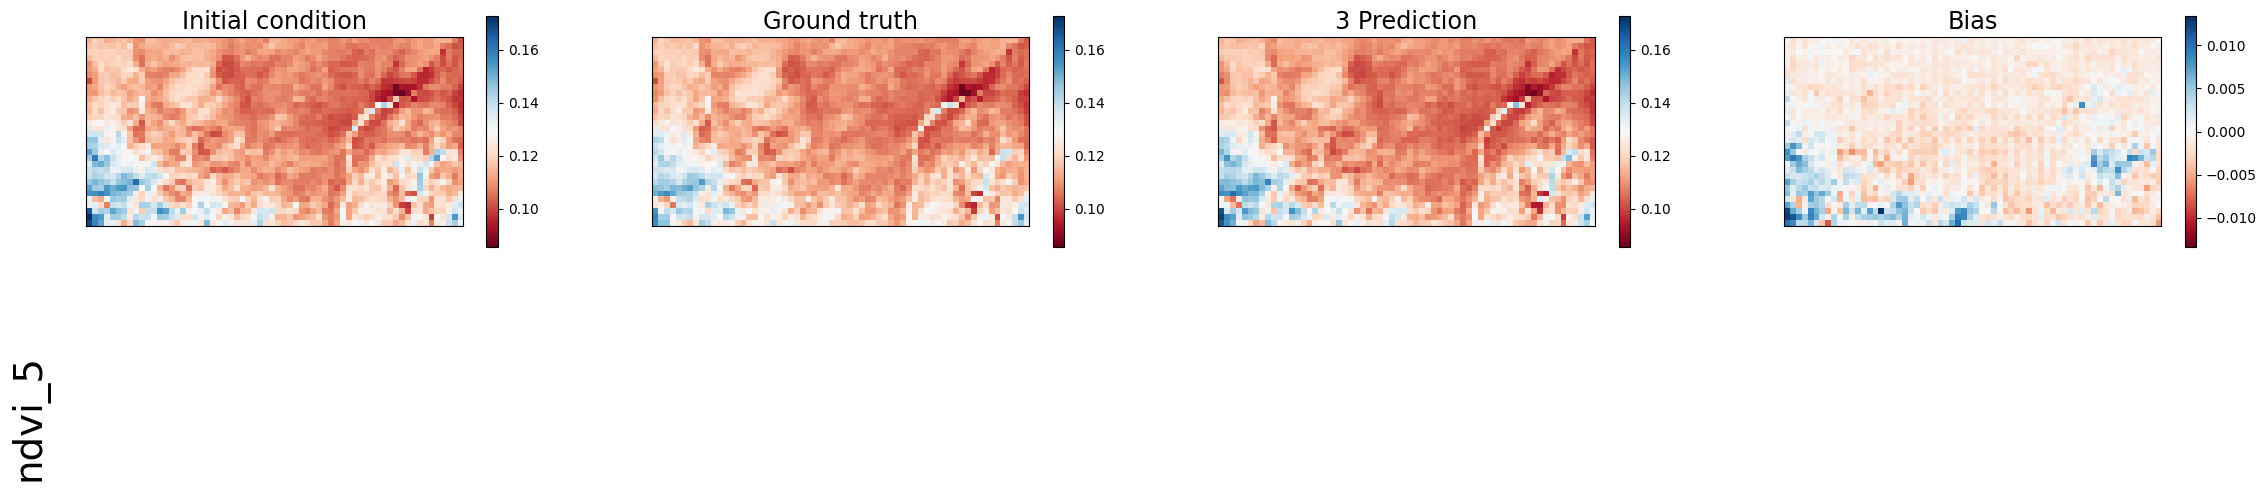

In [27]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 2, data_path=None)

#### RFH

In [4]:
task = "20 days"
var = 'rfh'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        "lattitude",
        'lst_5','rfh','r1h_dekad','r2h_dekad','r3h_dekad','ndvi_5']
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 10,
    "decoder_depth": 2,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_015.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/CHIRPS_MODIS/data_npz',
    variables=[
      'lst_5','rfh','r1h_dekad','r2h_dekad','r3h_dekad','ndvi_5'],
    out_variables=[var],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

datamodule.setup()

NameError: name 'TASK_TO_RANGE' is not defined

**We give as input the file <span style="color: blue;">Data/CHIRPS_MODIS/data_npz/test/2022_0.npz </span>**

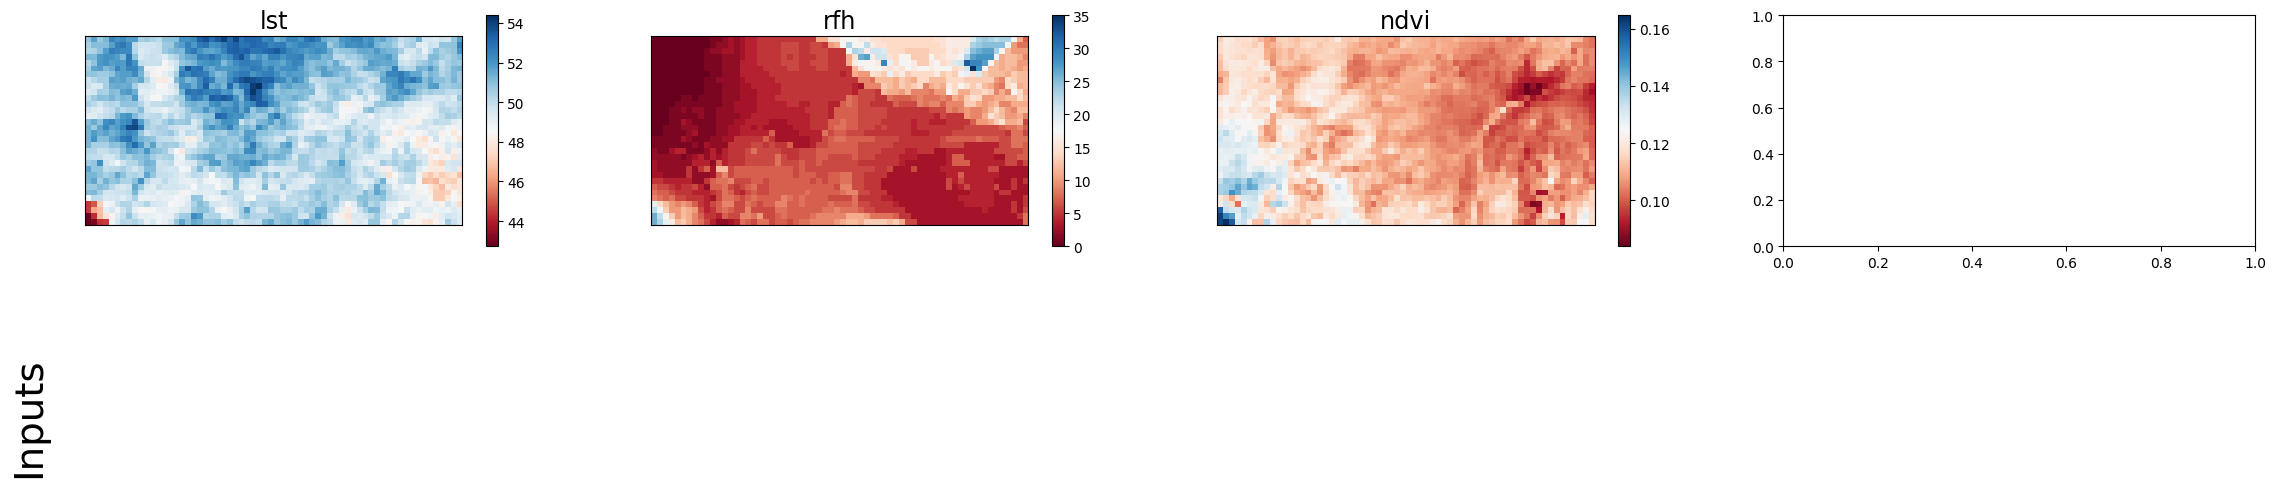

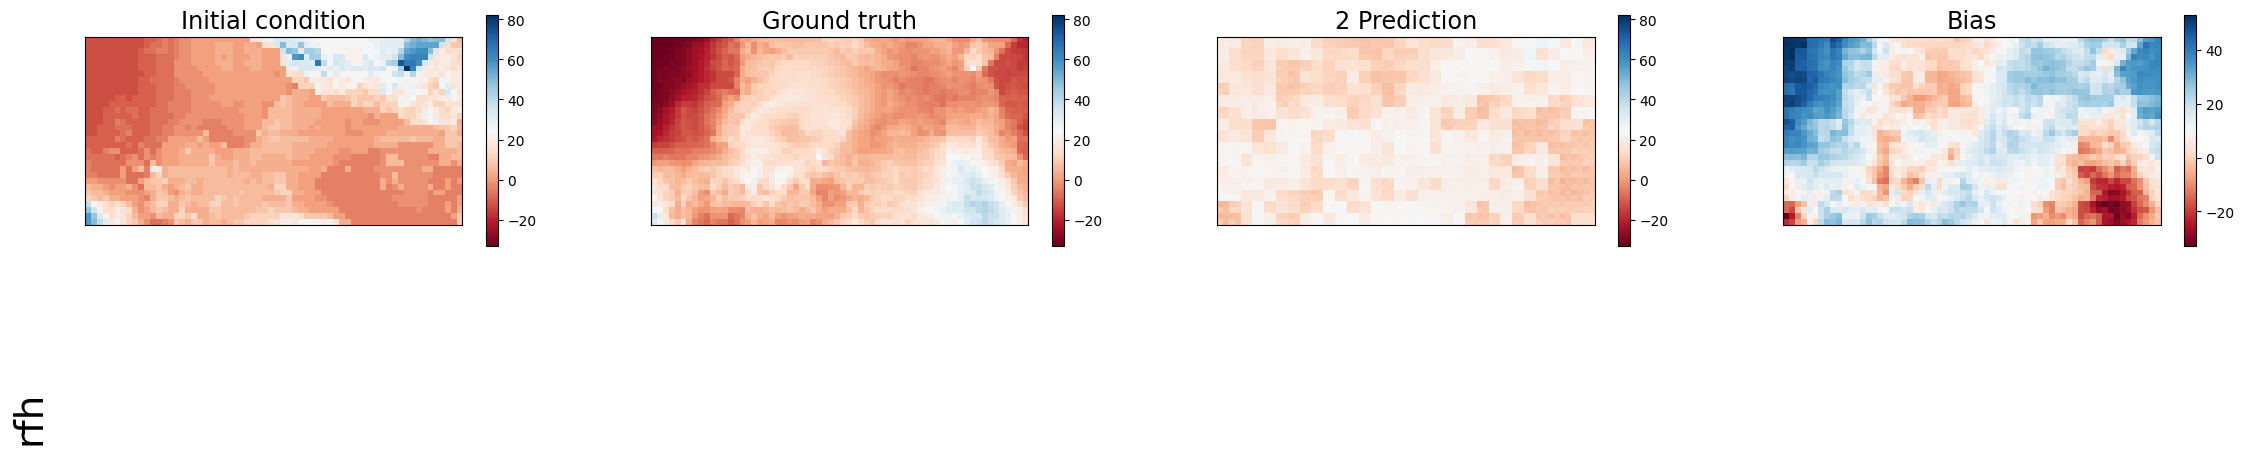

In [133]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 1, data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz")

**We give as input a random batch**

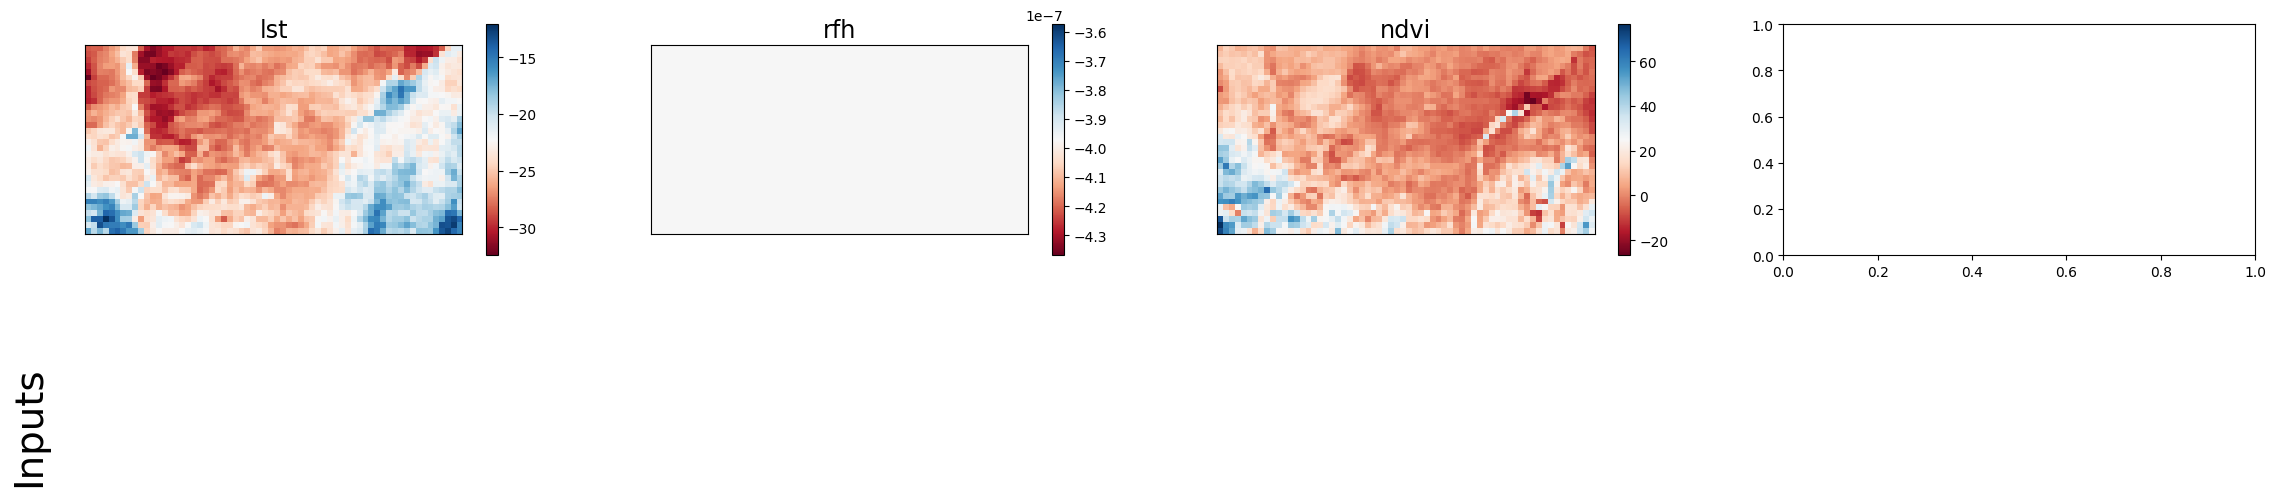

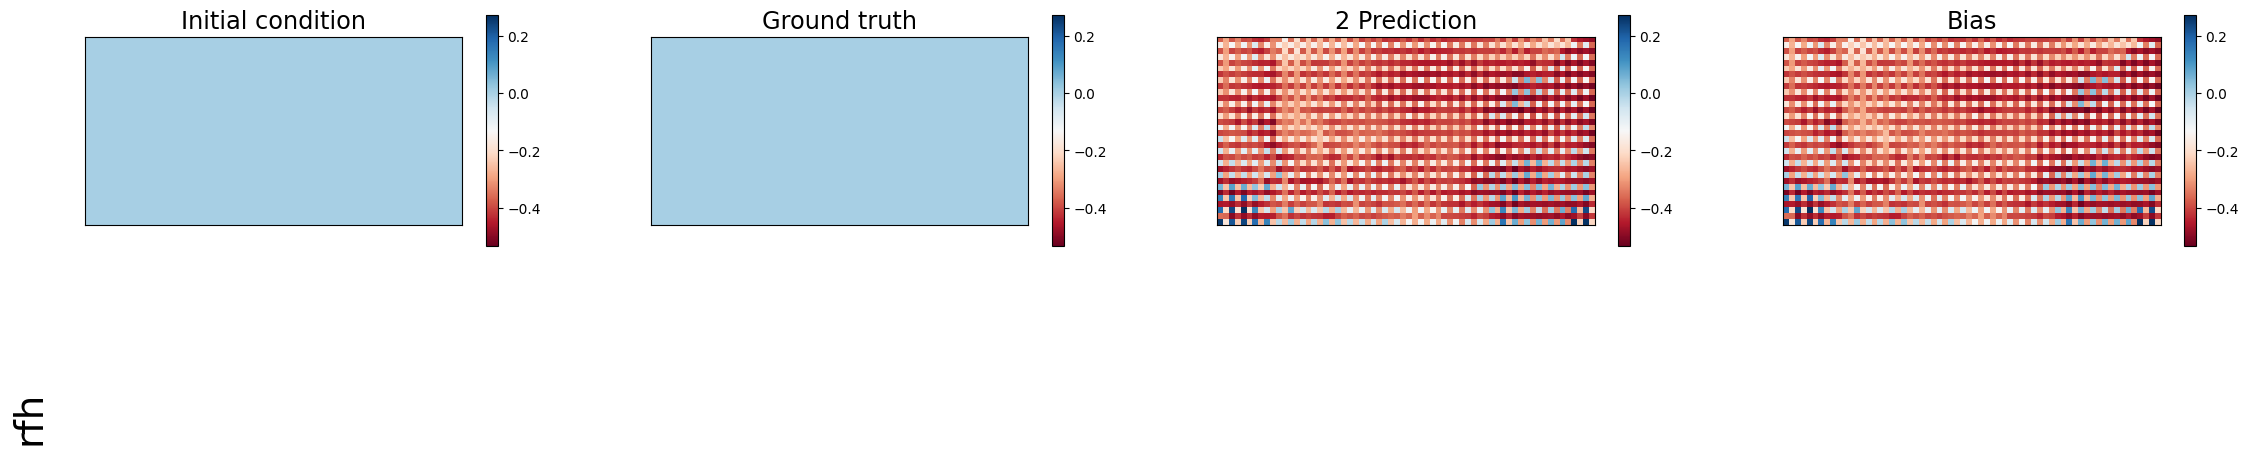

In [134]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 1, data_path=None)

#### NDVI

In [135]:
task = "20 days"
var = 'ndvi_5'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        "lattitude",
        "rfh",
        "ndvi_5",
        "lst_5"
        ]
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 10,
    "decoder_depth": 2,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_028-v1.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/CHIRPS_MODIS/data_npz',
    variables=[
      'lst_5','rfh','ndvi_5'],
    out_variables=['ndvi_5'],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
print(mean_norm, std_norm )
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_028-v1.ckpt
embedding_size 1024
<All keys matched successfully>
[0.11201597] [0.01123807]


**We give as input the file**

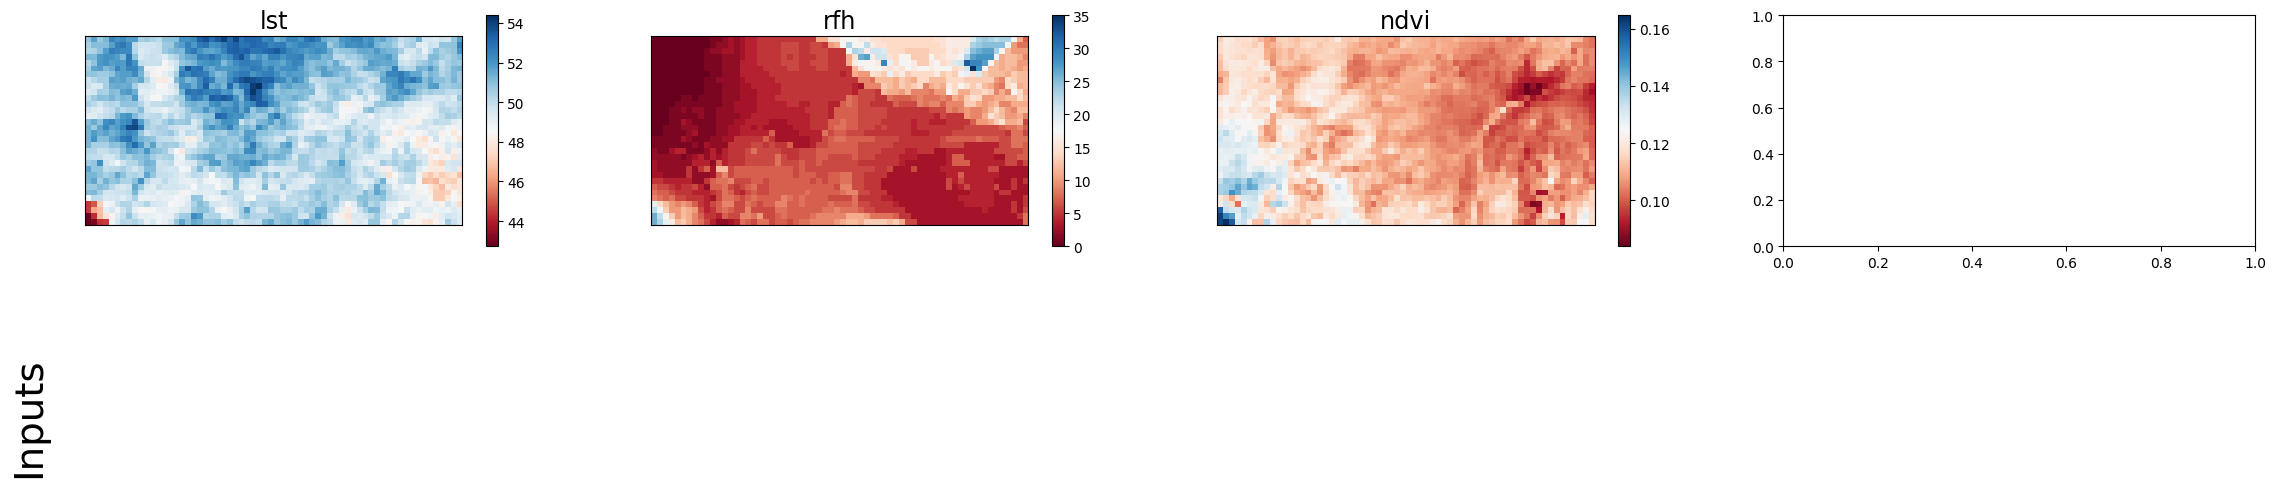

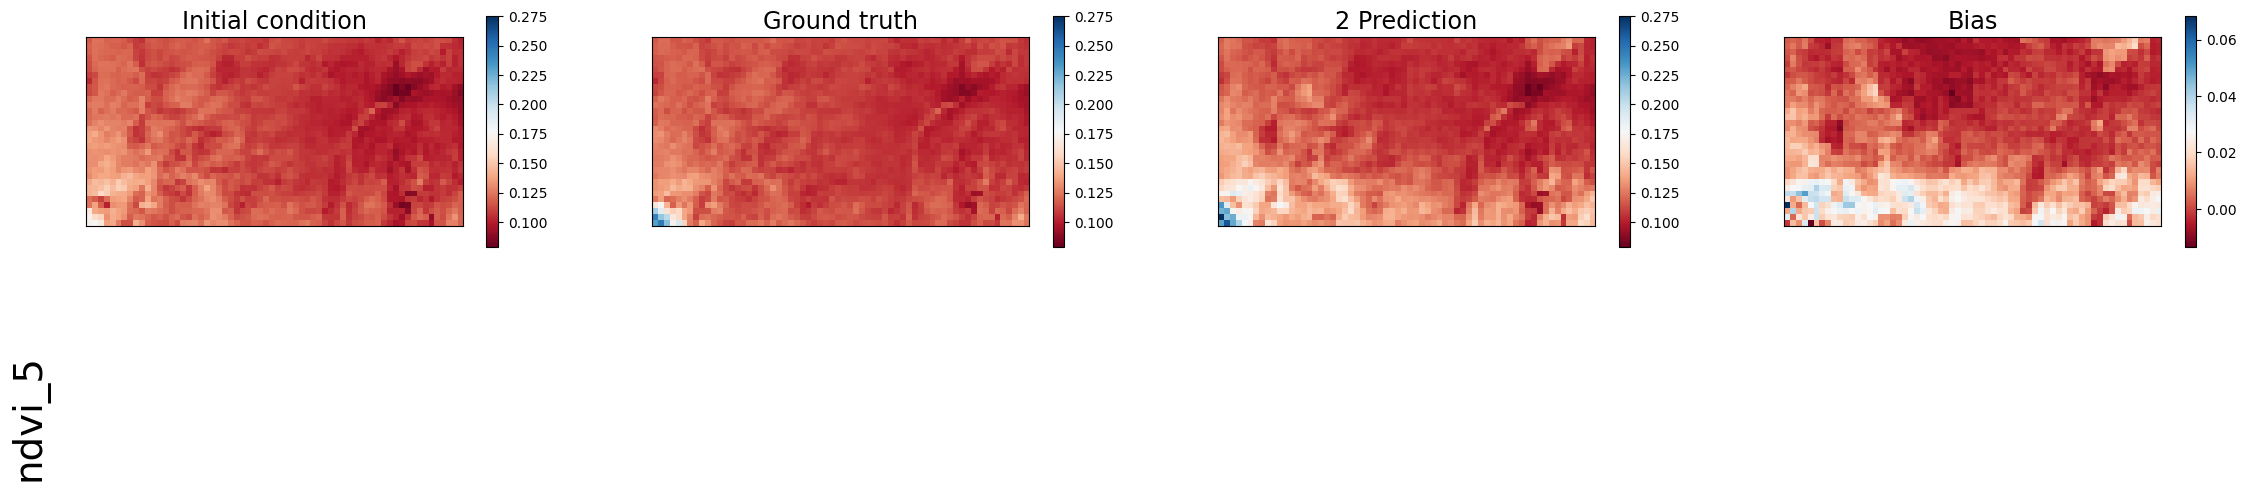

In [136]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 2, data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz")

**We give as input a random batch**

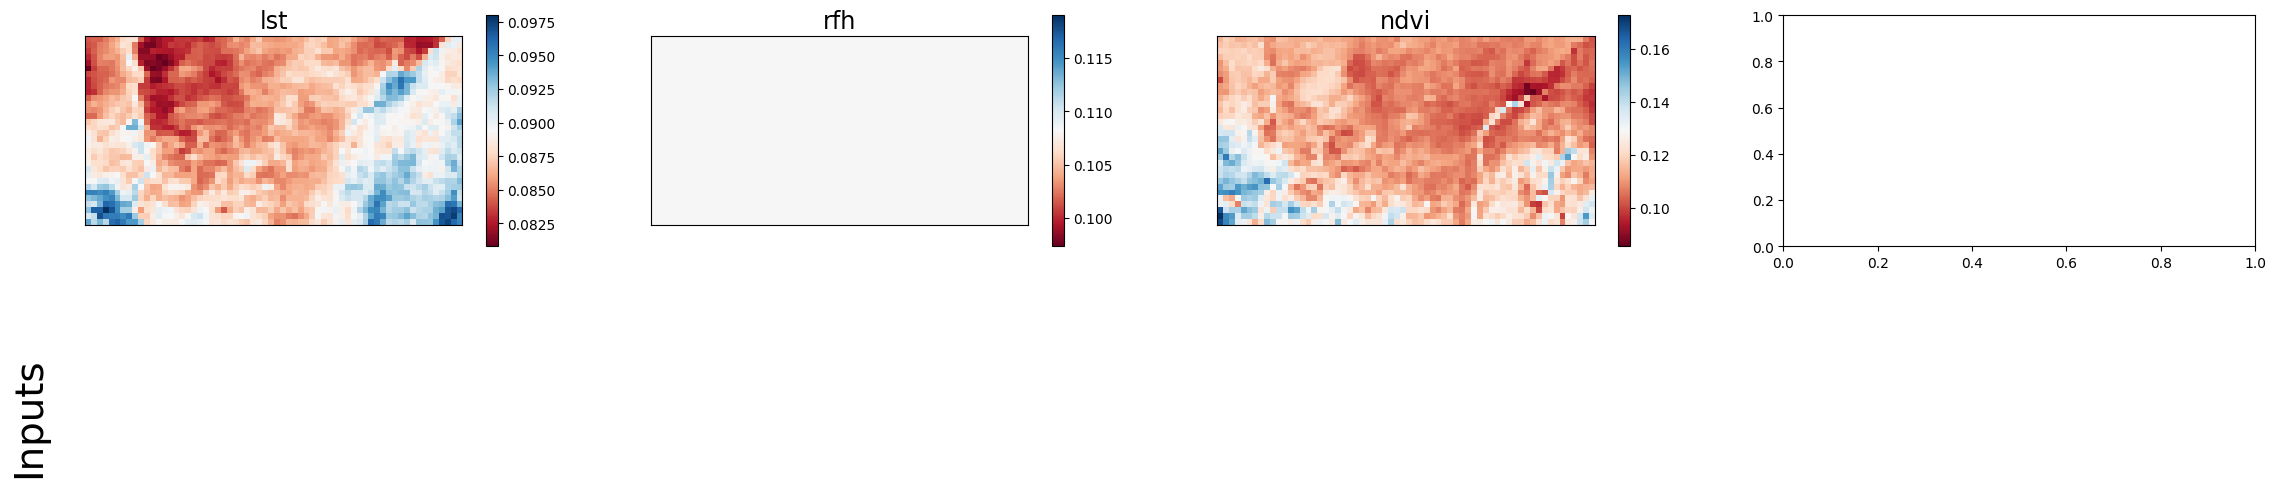

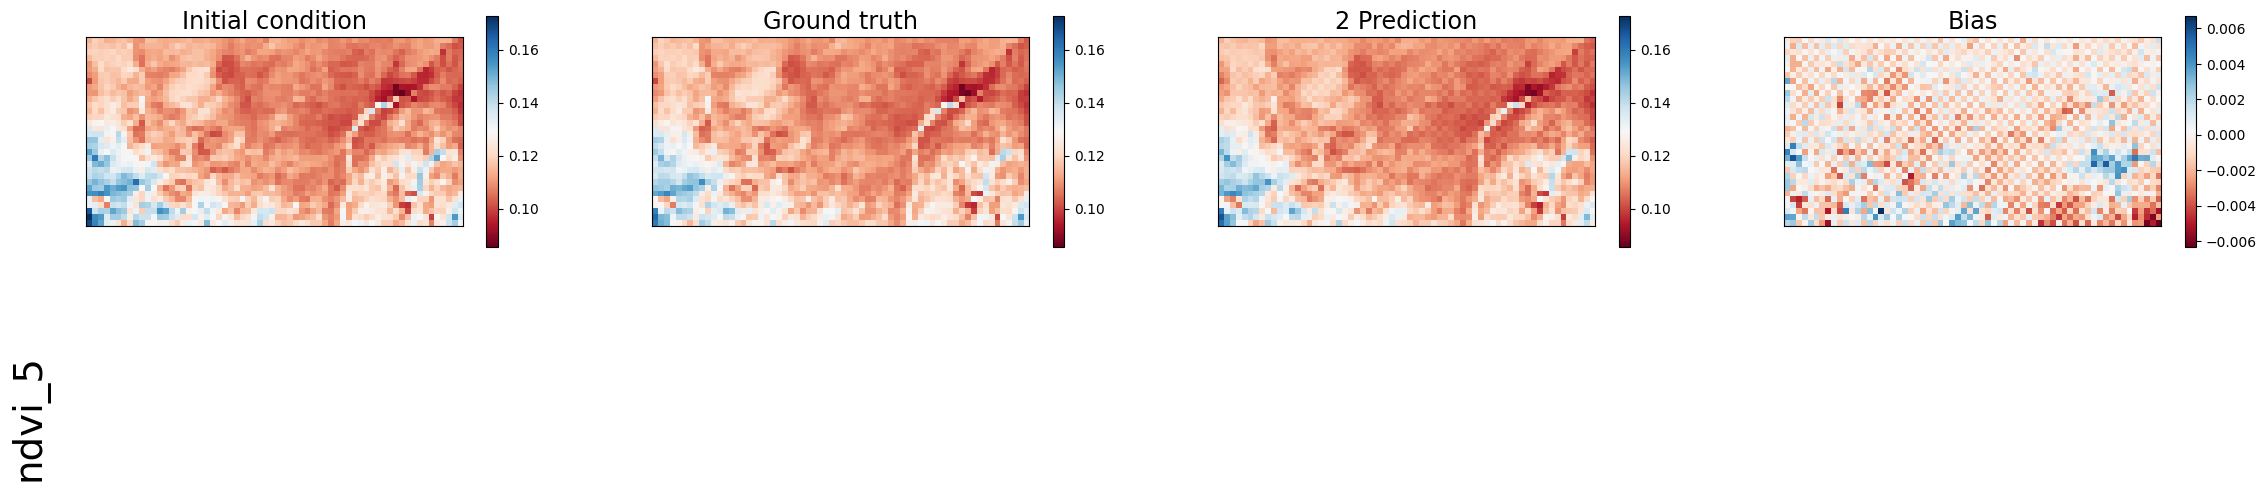

In [137]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 2, data_path=None)

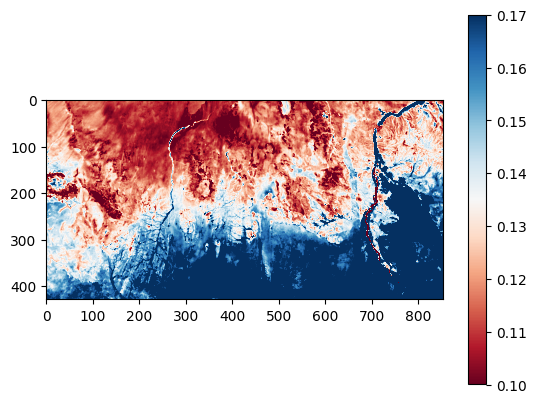

In [50]:
plt.figure()
plt.imshow(data, vmin=0.1, vmax=0.17)
plt.set_cmap(cmap=plt.cm.RdBu)
plt.colorbar()
plt.show()

### Forecast on 60 days

#### NDVI

In [60]:
task = "60 days"
var = 'ndvi_5'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': ['lst_5','rfh', 'ndvi_5','r1h_dekad','r2h_dekad','r3h_dekad']
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 8,
    "decoder_depth": 2,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_025.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/forecasting/data_npz',
    variables=[
      'lst_5','rfh','ndvi_5'],
    out_variables=['ndvi_5'],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
print(mean_norm, std_norm )
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_025.ckpt
<All keys matched successfully>
[0.11208917] [0.01134096]


**We give as input a random batch**

Got the 17th batch!


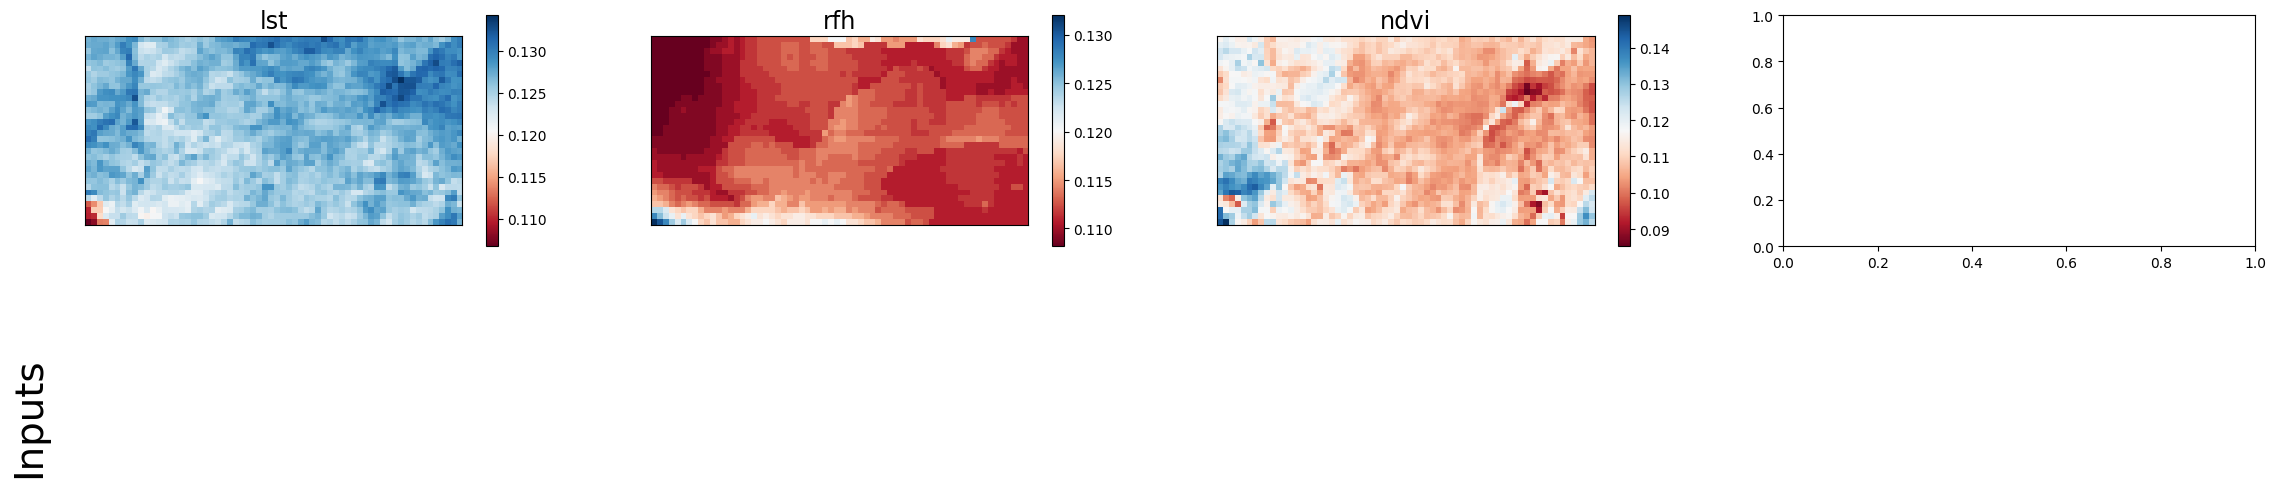

0.08320762 0.2825333


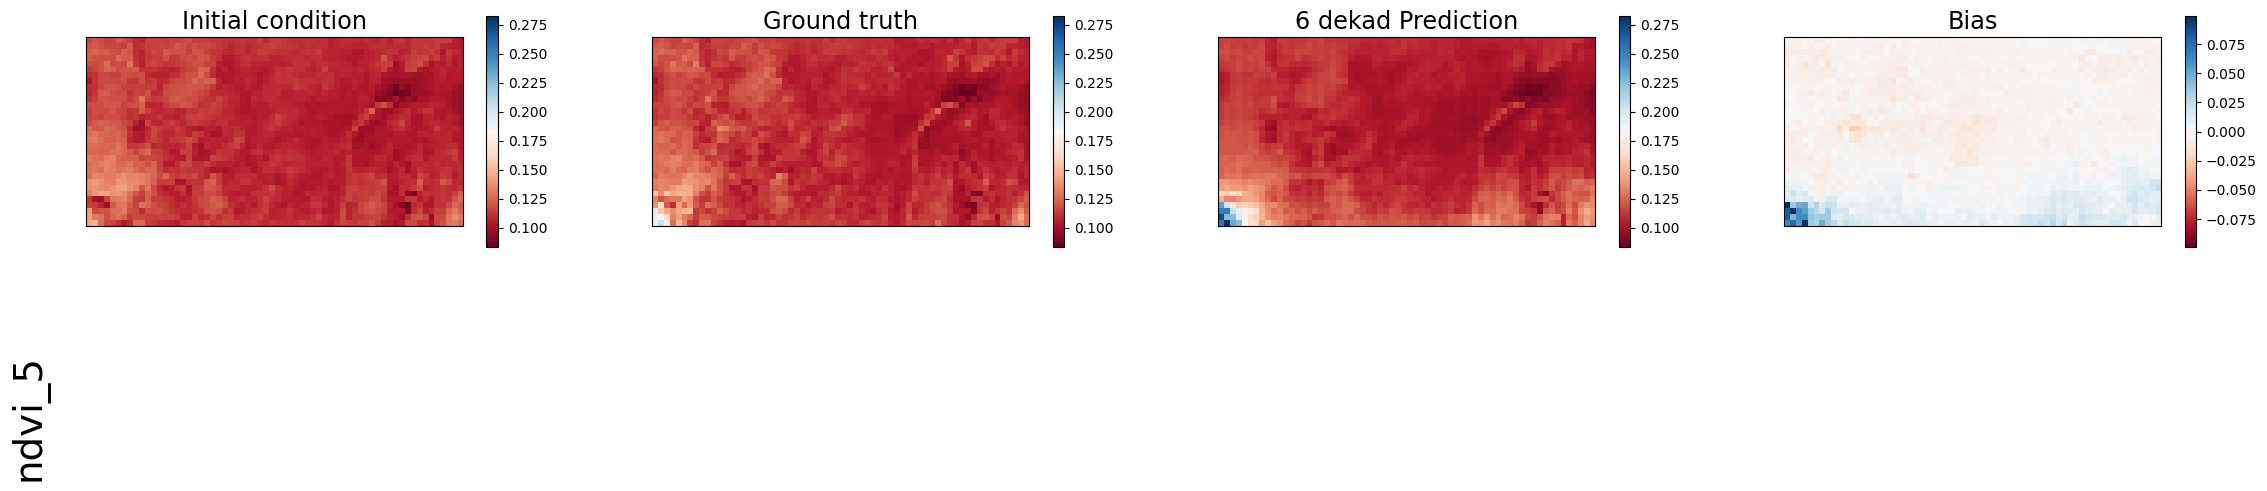

In [132]:
gt  = visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 2, data_path=None)

In [125]:
ndvi_5_lta = ndvi_5.sel(time=slice("2002-07-01","2018-06-21"))
ndvi_5_lta  = ndvi_5_lta .groupby(ndvi_5_lta.time.dt.strftime("%m-%d")).mean()

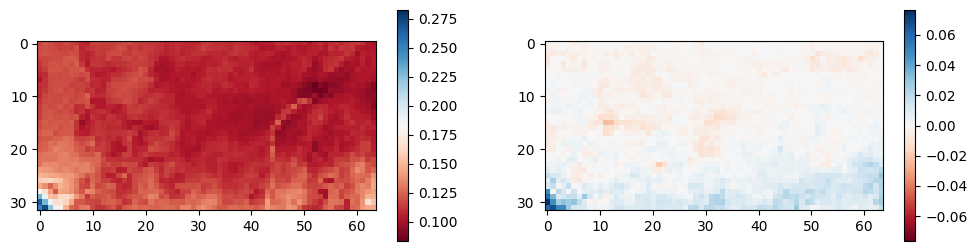

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
im1 = axs[0].imshow(ndvi_5_lta[23], cmap=plt.cm.RdBu, vmin = 0.08320762, vmax= 0.2825333)
cbar1 = fig.colorbar(im1, ax=axs[0])
data = ndvi_5_lta[23].values - gt.detach().squeeze().cpu().numpy()
im2 = axs[1].imshow(data, cmap=plt.cm.RdBu, vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
cbar2 = fig.colorbar(im2, ax=axs[1])
plt.show()

### Forecast on 90 days

#### NDVI

In [163]:
task = "90 days"
var = 'ndvi_5'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': ['lst_5','rfh', 'ndvi_5','r1h_dekad','r2h_dekad','r3h_dekad']
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 8,
    "decoder_depth": 2,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_014.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/forecasting/data_npz',
    variables=[
      'lst_5','rfh','ndvi_5'],
    out_variables=['ndvi_5'],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
print(mean_norm, std_norm )
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_014.ckpt
<All keys matched successfully>
[0.11208917] [0.01134096]


**We give as input a random batch**

Got the 17th batch!
self.var_map=== {'lst_5': 0, 'rfh': 1, 'ndvi_5': 2, 'r1h_dekad': 3, 'r2h_dekad': 4, 'r3h_dekad': 5}
self.var_map=== {'lst_5': 0, 'rfh': 1, 'ndvi_5': 2, 'r1h_dekad': 3, 'r2h_dekad': 4, 'r3h_dekad': 5}


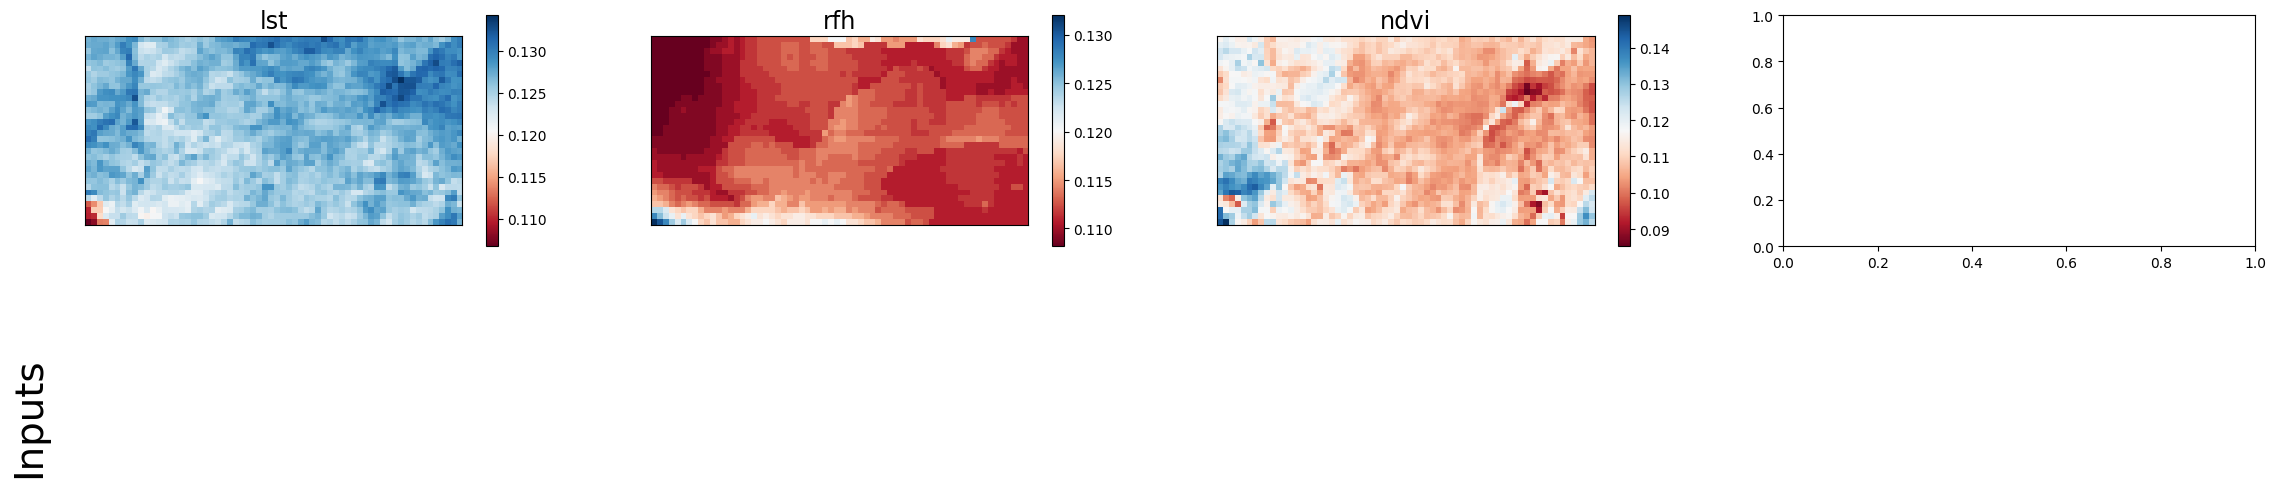

0.084 0.25162822


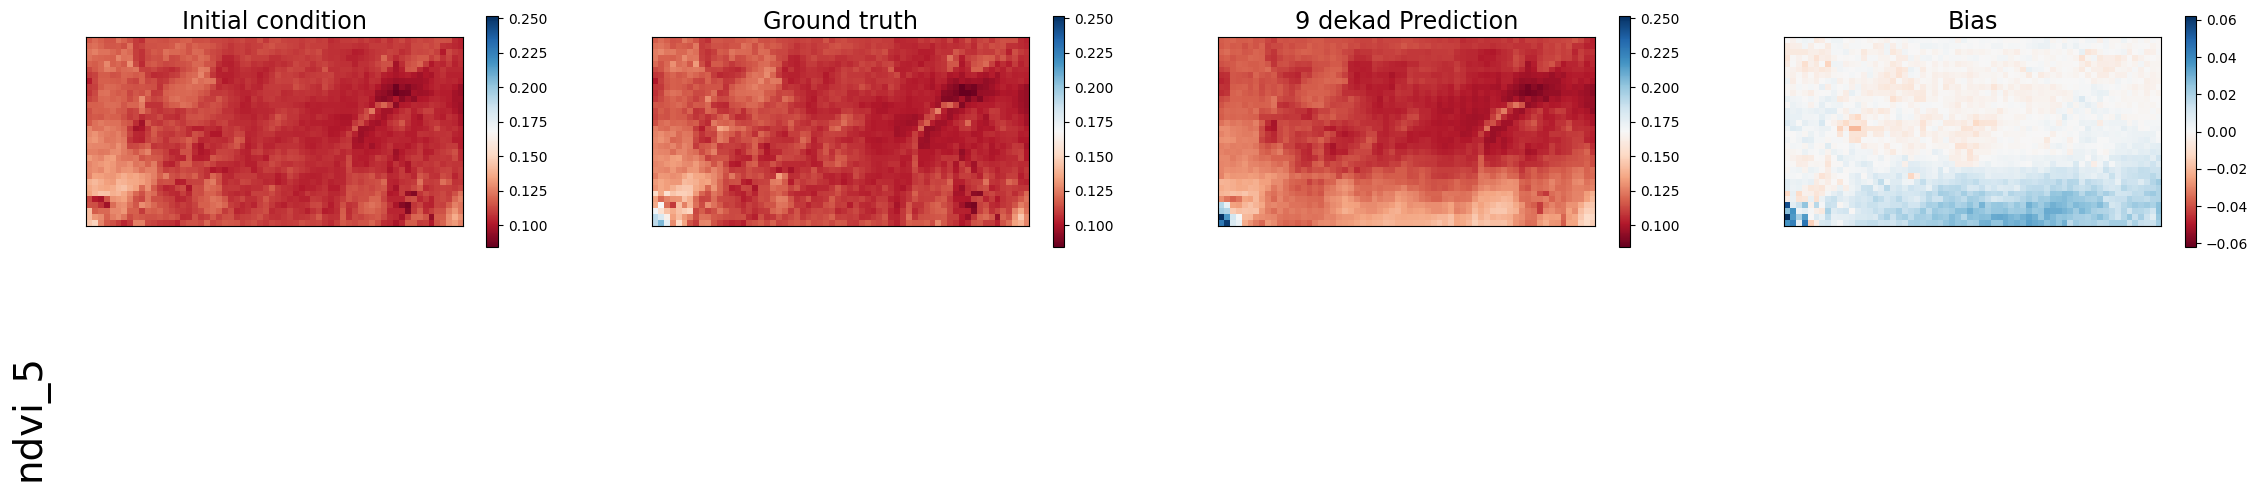

tensor([[[[0.1172, 0.1212, 0.1180,  ..., 0.1136, 0.1052, 0.1035],
          [0.1217, 0.1228, 0.1202,  ..., 0.1068, 0.1056, 0.1037],
          [0.1250, 0.1273, 0.1239,  ..., 0.1140, 0.1095, 0.1063],
          ...,
          [0.1703, 0.1549, 0.1434,  ..., 0.1263, 0.1354, 0.1216],
          [0.1897, 0.1812, 0.1633,  ..., 0.1317, 0.1452, 0.1275],
          [0.1900, 0.2052, 0.1756,  ..., 0.1344, 0.1385, 0.1263]]]],
       device='cuda:0')

In [164]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 2, data_path=None)

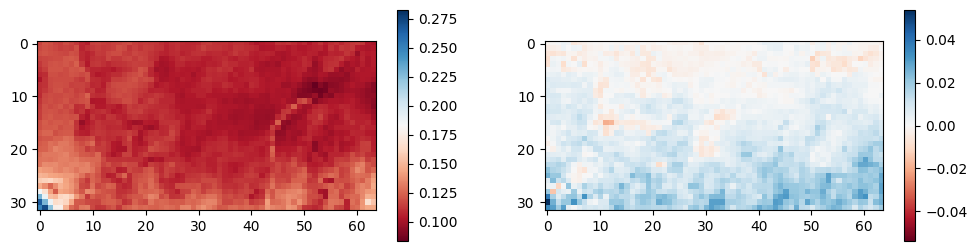

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
im1 = axs[0].imshow(ndvi_5_lta[23], cmap=plt.cm.RdBu, vmin = 0.08320762, vmax= 0.2825333)
cbar1 = fig.colorbar(im1, ax=axs[0])
data = ndvi_5_lta[26].values - gt.detach().squeeze().cpu().numpy()
im2 = axs[1].imshow(data, cmap=plt.cm.RdBu, vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
cbar2 = fig.colorbar(im2, ax=axs[1])
plt.show()

# Results if we add other variables

In [2]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F

from climax.global_forecast.datamodule import GlobalForecastDataModule
from climax.global_forecast.module import GlobalForecastModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX

from src.climax.global_forecast.module import GlobalForecastModule
from src.climax.global_forecast.datamodule import GlobalForecastDataModule

TASK_TO_RANGE = {
    '0 days' : 0,
    '10 days' : 1,
    '40 days': 4,
    '50 days': 5,
    '60 days': 6,
    '20 days': 2,
    '30 days': 3,
}

/envs/hdc/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Utils

In [9]:
def plot_pred(tensors, var_name, pred_task, same_colorbar=True):
    index = 0
    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    image1_np = tensors[0].detach().squeeze().cpu().numpy()
    image2_np = tensors[1].detach().squeeze().cpu().numpy()
    image3_np = tensors[2].detach().squeeze().cpu().numpy()
    vmin = min(np.min(image1_np), np.min(image2_np), np.min(image3_np))
    vmax = max(np.max(image1_np), np.max(image2_np), np.max(image3_np))

    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        if same_colorbar and i<3 : 
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy(),vmin=vmin, vmax=vmax)

        else : 
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off
        
        
    
    axes[index][0].text(-10, 64, var_name, fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"Initial condition", fontsize='xx-large')
    axes[index][1].set_title(f"Ground truth", fontsize='xx-large')
    axes[index][2].set_title(f"{pred_task} Prediction", fontsize='xx-large')
    axes[index][3].set_title(f"Bias", fontsize='xx-large')

    plt.show()
    

def plot_inputs(tensors, var_name, pred_task):
    index = 0
    fig, axes = plt.subplots(1, 6, figsize=(28, 3), squeeze = False)
    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off
        
        

    axes[index][0].text(-10, 64, "Inputs", fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"lst", fontsize='xx-large')
    axes[index][1].set_title(f"rfh", fontsize='xx-large')
    axes[index][2].set_title(f"r1h_dekad", fontsize='xx-large')
    axes[index][3].set_title(f"r2h_dekad", fontsize='xx-large')
    axes[index][4].set_title(f"r3h_dekad", fontsize='xx-large')
    axes[index][5].set_title(f"ndvi", fontsize='xx-large')
   

    plt.show()
    
    
def preprocess (pred_task,model_module, data_module,mean_norm, std_norm, var_id,data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz", verbose=True):
    '''Normalize data to do the forward'''
    
    data  = np.load(data_path)
    
    rfh = data['rfh']
    r1h_dekad = data['r1h_dekad']
    r2h_dekad = data['r2h_dekad']
    r3h_dekad = data['r3h_dekad']
    lst_5 = data['lst_5']
    ndvi_5 = data['ndvi_5']
    
    
    rfh_tensor = torch.from_numpy(rfh).type(torch.float32)
    r1h_dekad_tensor = torch.from_numpy(r1h_dekad).type(torch.float32)
    r2h_dekad_tensor = torch.from_numpy(r2h_dekad).type(torch.float32)
    r3h_dekad_tensor = torch.from_numpy(r3h_dekad).type(torch.float32)
    lst_5_tensor = torch.from_numpy(lst_5).type(torch.float32)
    ndvi_5_tensor = torch.from_numpy(ndvi_5).type(torch.float32)
    data_one_dekad =  torch.cat((lst_5_tensor,rfh_tensor,r1h_dekad_tensor, r2h_dekad_tensor, r3h_dekad_tensor, ndvi_5_tensor), dim=1)
    
    x_input = data_one_dekad[0].unsqueeze(0)  
    y_input =  data_one_dekad[pred_task,var_id].unsqueeze(0).unsqueeze(0)
    
    mean = torch.mean(x_input, dim=(0, 2, 3))
    std = torch.std(x_input, dim=(0, 2, 3))
    # Convert the mean and std tensors to lists
    mean_list = mean.tolist()
    std_list = std.tolist()
    # Define the transformation
    transform = transforms.Compose([
        transforms.Normalize(mean_list, std_list)
    ])
    norm_x = transform(x_input)
    
    mean = torch.mean(y_input, dim=(0, 2, 3))
    std = torch.std(y_input, dim=(0, 2, 3))
    # Convert the mean and std tensors to lists
    mean_list = mean.tolist()
    std_list = std.tolist()
    # Define the transformation
    transform = transforms.Compose([
        transforms.Normalize(mean_list, std_list)
    ])
    norm_y = transform(y_input)

    
    if verbose:
        print("Input")
        tensors = [x_input[:,0], x_input[:,1], x_input[:,2]]
        plot(tensors, var_name="", pred_task="", inp="inputs")
        
        print("Normalized")
        tensors = [norm_x[:,0], norm_x[:,1], norm_x[:,2]]
        plot(tensors, var_name="", pred_task="", inp="inputs")
        
        print("Y Normalized")
        tensors = [norm_y[:,0]]
        plot(tensors, var_name="", pred_task="", inp="inputs")
    
    return x_input, y_input, norm_x, norm_y
    
    
    


In [ ]:
 preprocess (2,model, datamodule,mean_norm, std_norm, 2,data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz", verbose=True)

## Regional Forecast 

In [11]:
def visualize_forecast(model_module, data_module,mean_norm, std_norm, pred_task, var_name, var_id,data_path=False, save_path = None):
    model_module.eval()
    model_module.cuda()

    model_module.eval()
    model_module.cuda()

    dataloader = data_module.test_dataloader()
    x, y, lead_times, in_vars, out_vars = next(iter(dataloader))
    

    lead_times = lead_times.cuda()
            
    if data_path!=None:
        x_input, y_input, norm_x, norm_y = preprocess (pred_task,model_module, data_module,mean_norm, std_norm,var_id,data_path, verbose=False)
        x = norm_x
        y = norm_y
    
    
    x = x.cuda()
    y = y.cuda()
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, None, model_module.lat)
    
    inv_normalize = model_module.denormalization

    if data_path!=None:
        tensors = [x_input[:,0],x_input[:,1], x_input[:,2], x_input[:,3],x_input[:,4], x_input[:,5]]
        
    else:
        tensors = [inv_normalize(x[:,0]), inv_normalize(x[:,1]), inv_normalize(x[:,2]),inv_normalize(x[:,3]), inv_normalize(x[:,4]), inv_normalize(x[:,5])]
    plot_inputs(tensors, var_name, pred_task)
    
    
    x = x[:, var_id,:]
    init_condition, gt = inv_normalize(x), inv_normalize(y)
    pred = inv_normalize(pred)
    bias = pred - gt
    tensors = [init_condition, gt, pred, bias]
    plot_pred(tensors, var_name, pred_task)
    plot_pred(tensors, var_name, pred_task,same_colorbar=False)
        
    del x
    del y
    del pred   

### Forecast on 20 days

#### LST

In [127]:
task = "20 days"
var = 'lst_5'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        "lattitude",
        "rfh",
        "r1h_dekad",
        "r2h_dekad",
        "r3h_dekad",
        "ndvi_5",
        "lst_5"
        ]
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 10,
    "decoder_depth": 2,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_020-v1.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/CHIRPS_MODIS/data_npz',
    variables=[
      'lst_5','rfh','r1h_dekad','r2h_dekad','r3h_dekad','ndvi_5'],
    out_variables=[var],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_020-v1.ckpt
embedding_size 1024
<All keys matched successfully>


In [128]:
normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)



In [129]:
datamodule.setup()

**We give as input the file <span style="color: blue;">Data/CHIRPS_MODIS/data_npz/test/2022_0.npz </span>**

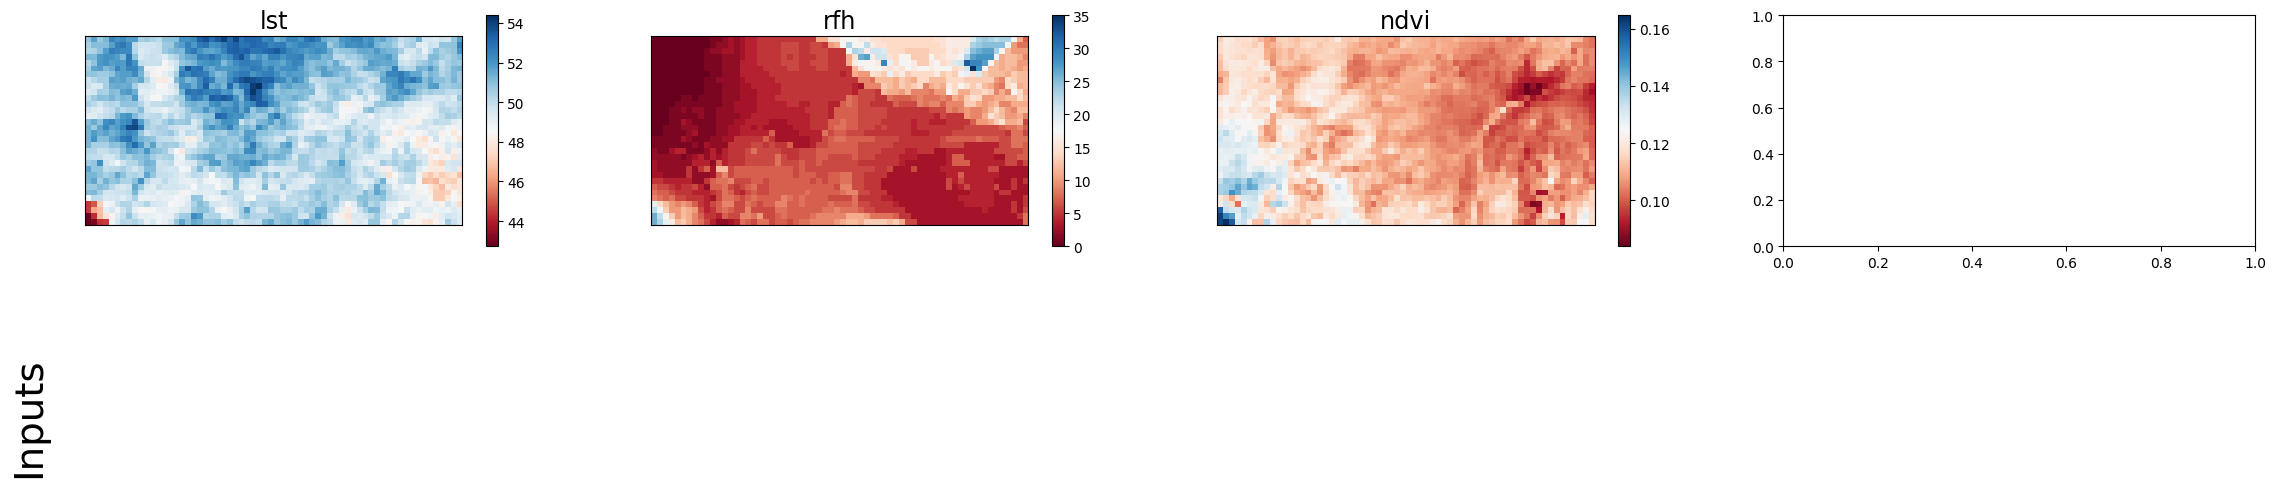

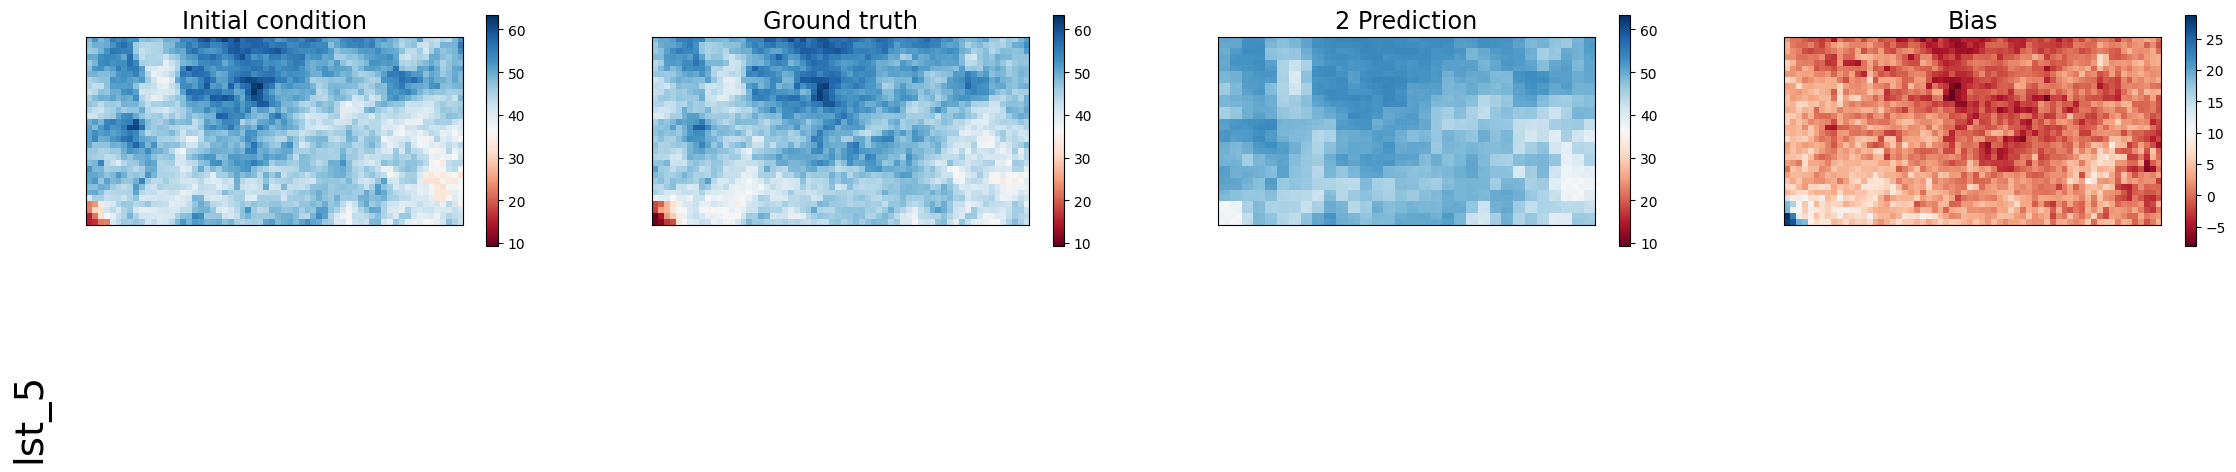

In [130]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 0, data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz")

**We give as input a random batch**

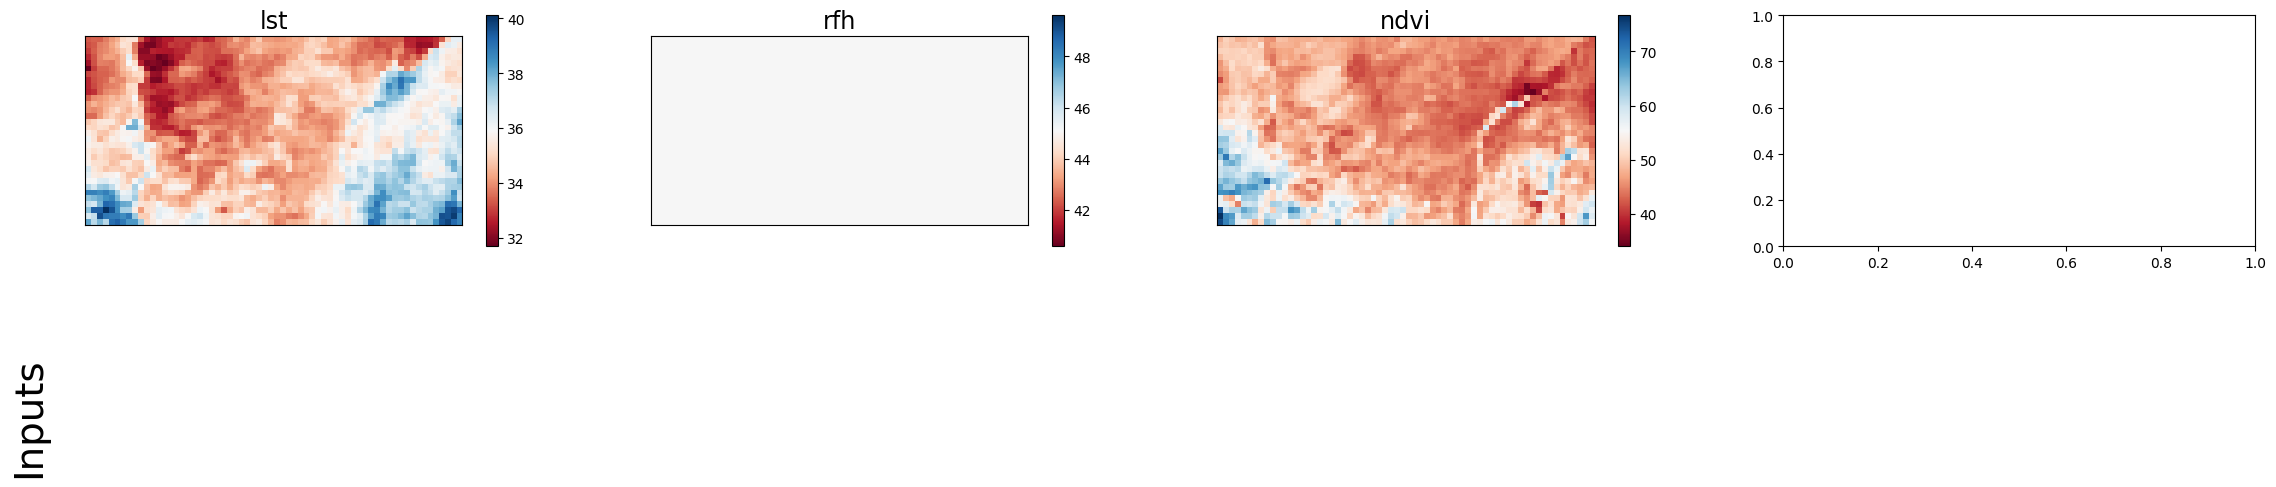

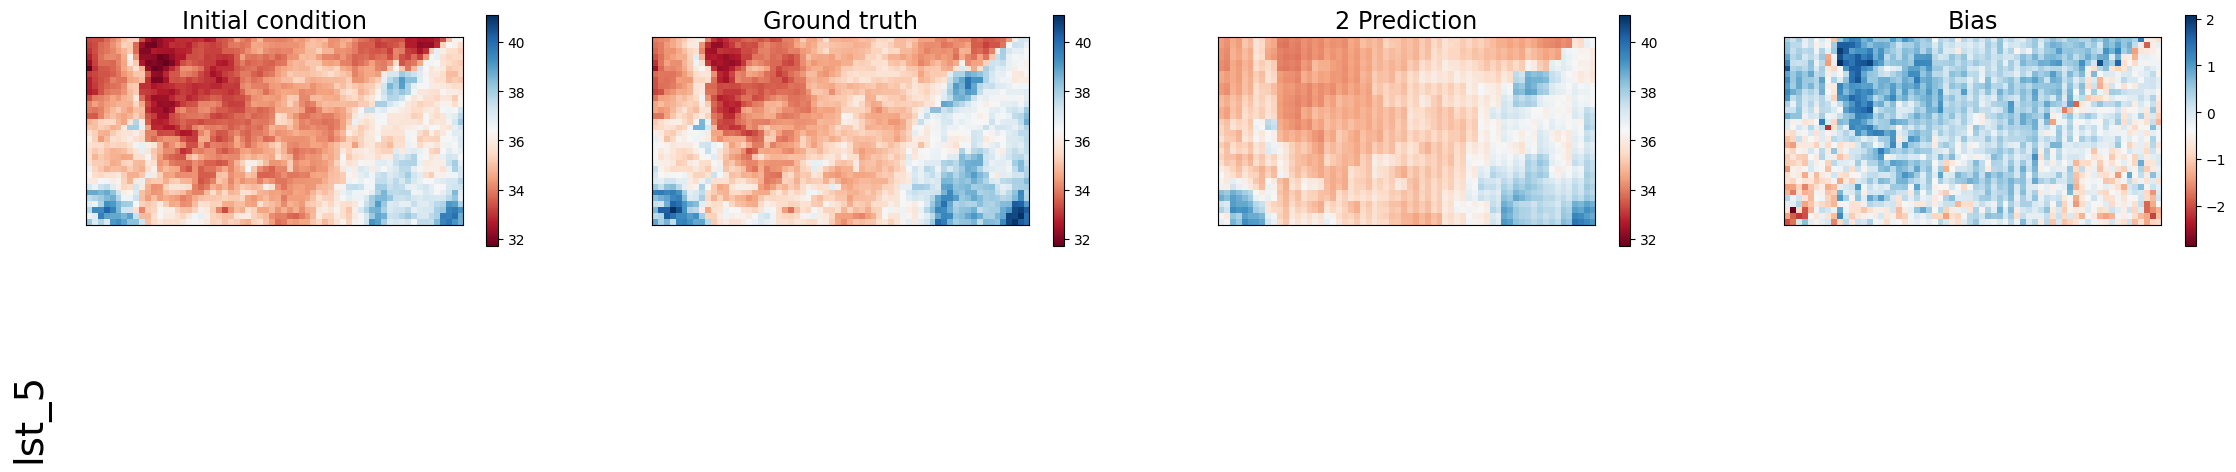

In [131]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 0, data_path=None)

#### RFH

In [15]:
task = "20 days"
var = 'rfh'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        'lst_5',
        'rfh',
        'r1h_dekad',
        'r2h_dekad',
        'r3h_dekad',
        'ndvi_5'
        ]
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 12,
    "decoder_depth": 3,
    "num_heads": 32,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_005.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/CHIRPS_MODIS/data_npz',
    variables=[
        'lst_5',
        'rfh',
        'r1h_dekad',
        'r2h_dekad',
        'r3h_dekad',
        'ndvi_5'],
    out_variables=[var],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_005.ckpt
embedding_size 1024
<All keys matched successfully>


**We give as input the file <span style="color: blue;">Data/CHIRPS_MODIS/data_npz/test/2022_0.npz </span>**

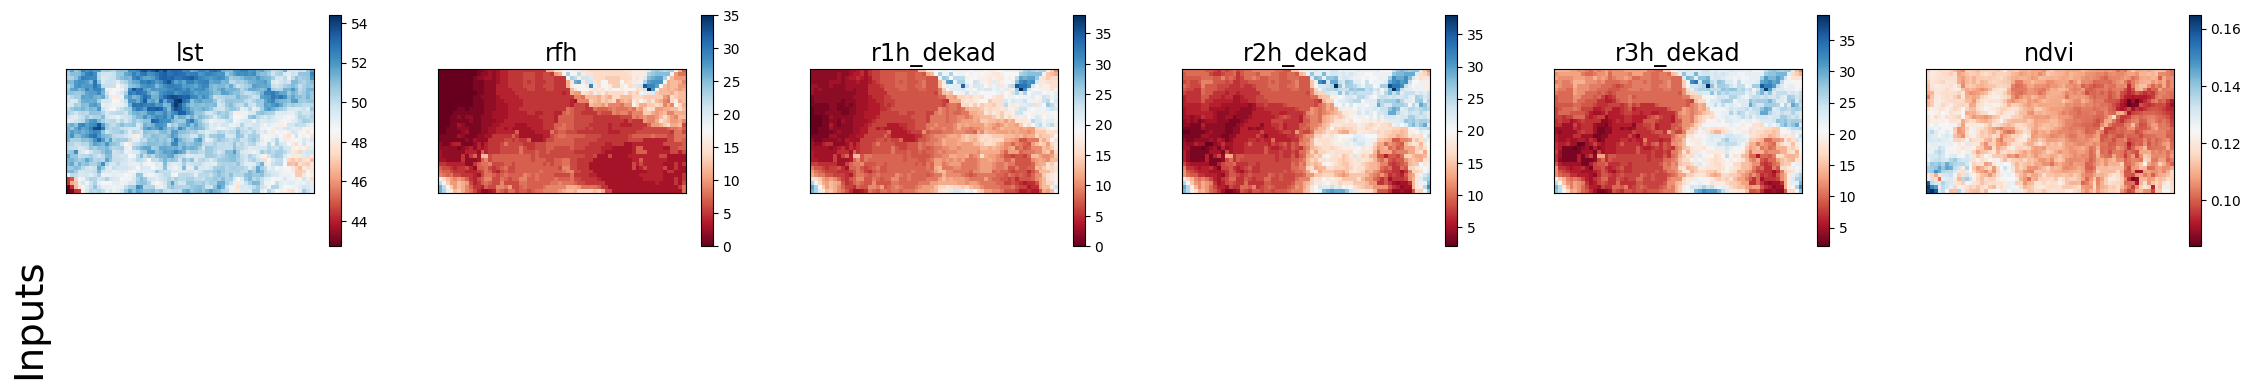

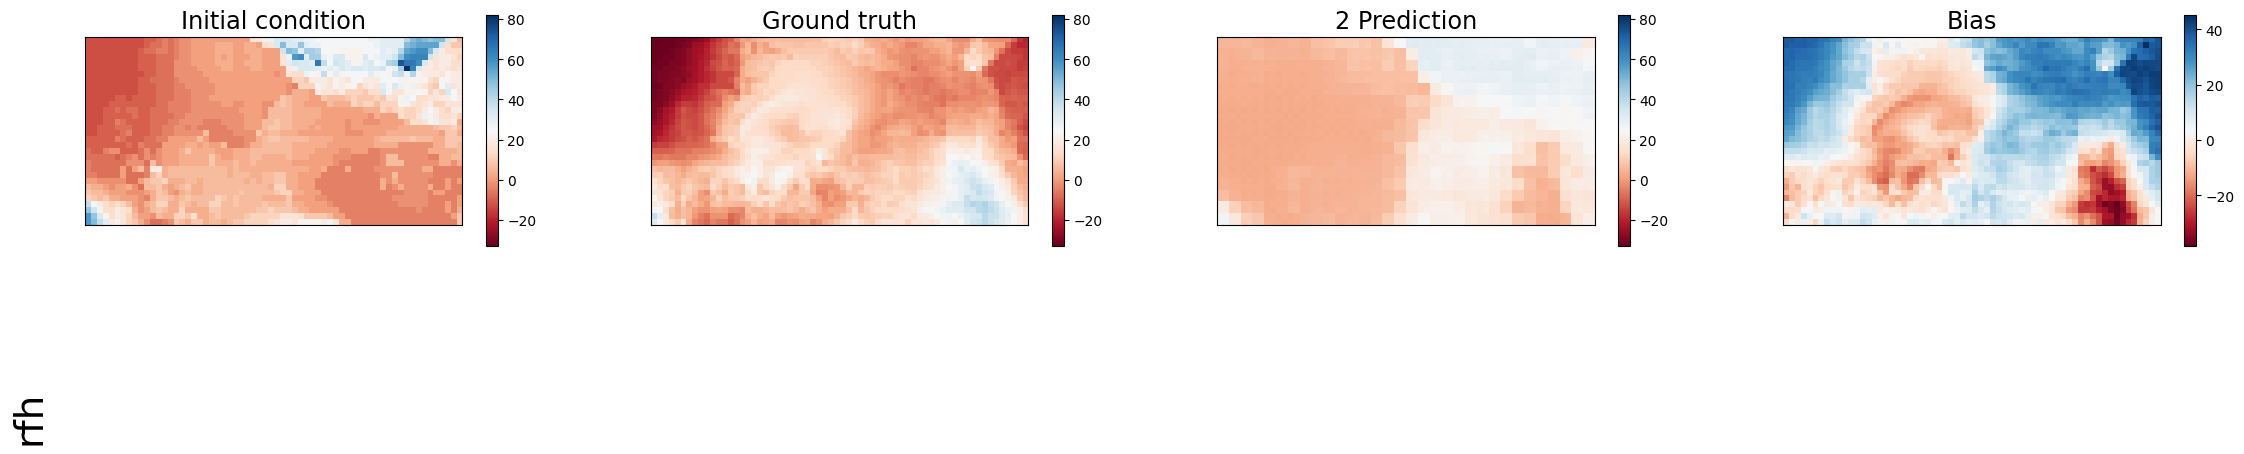

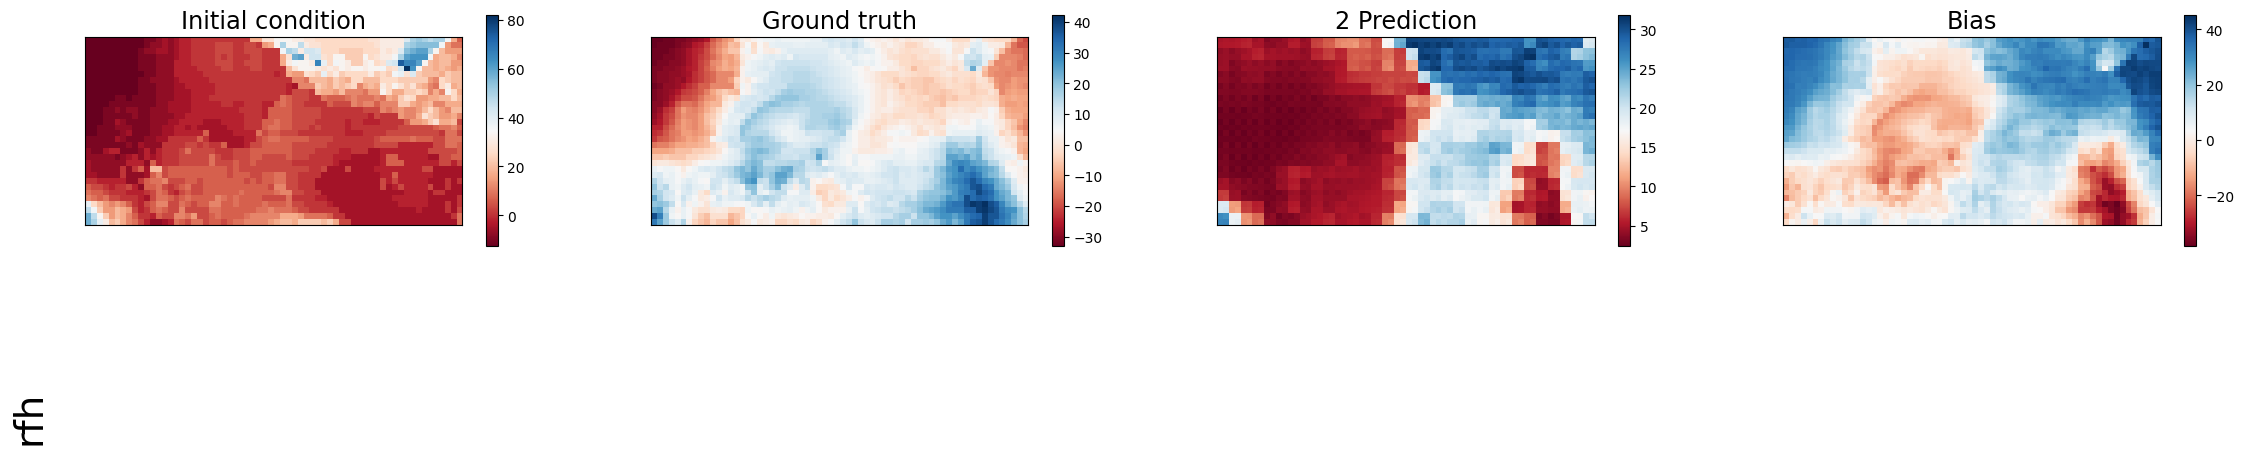

In [16]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 1, data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz")

**We give as input a random batch**

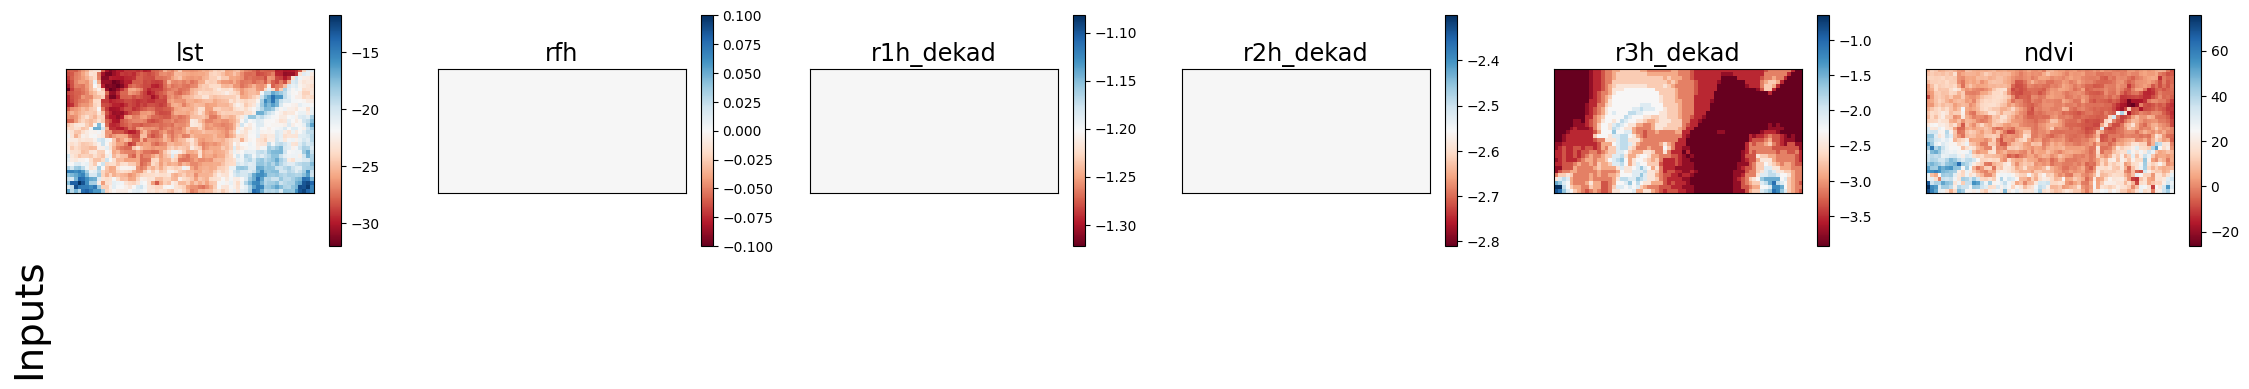

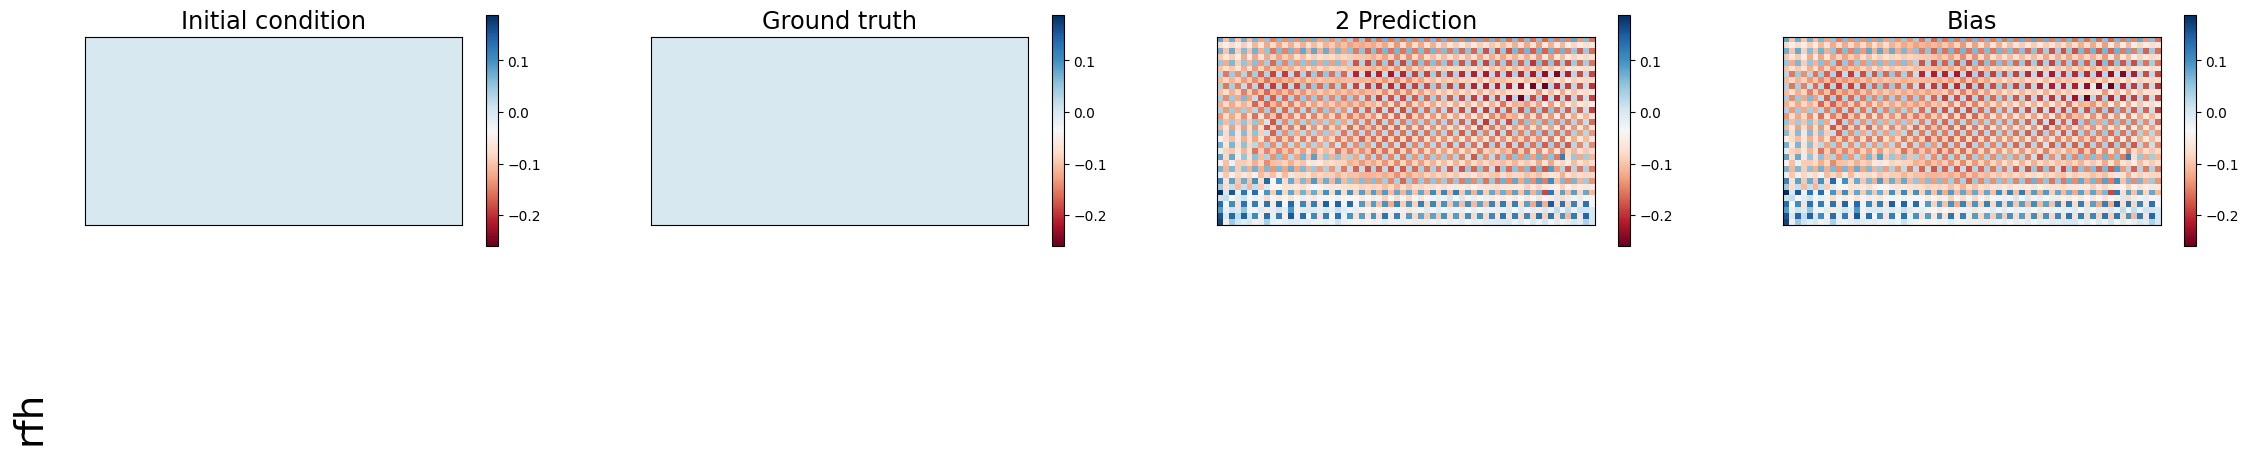

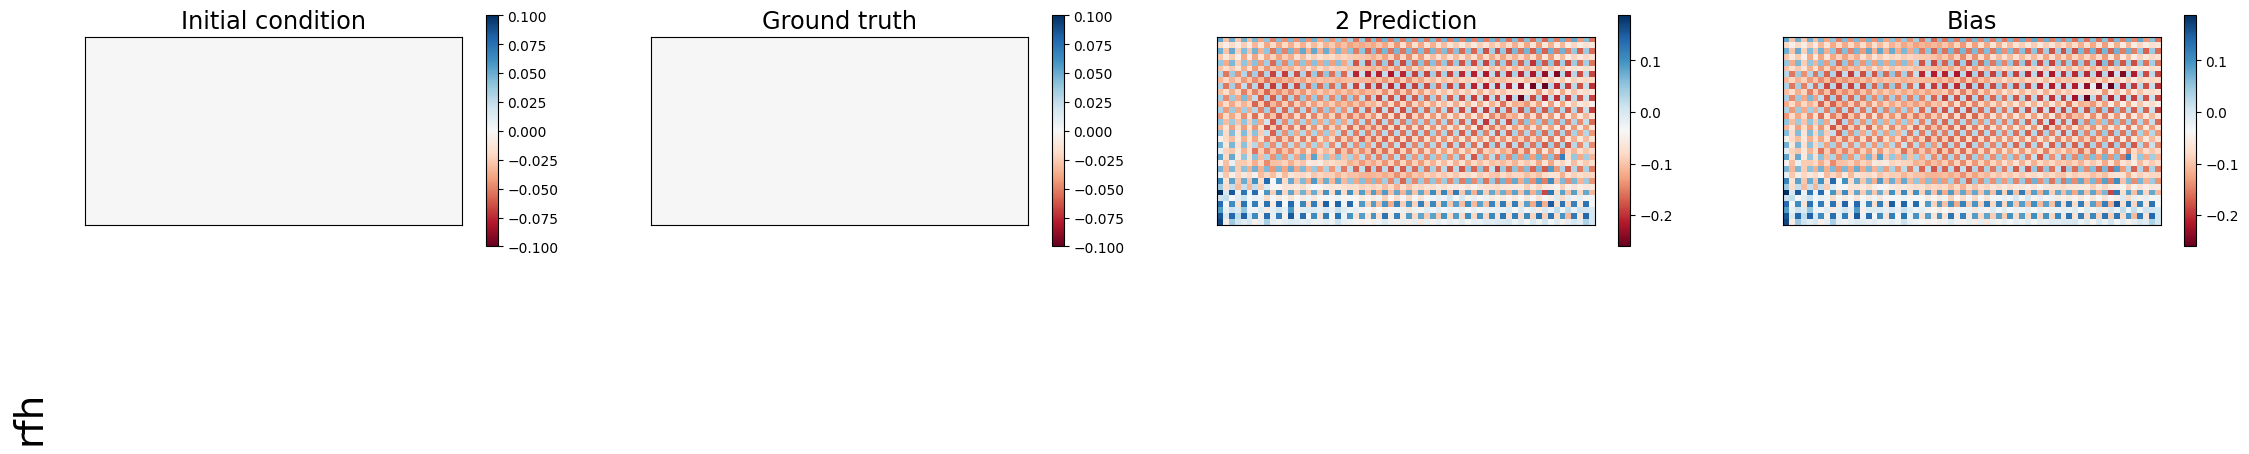

In [17]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 1, data_path=None)

#### NDVI

In [12]:
task = "20 days"
var = 'ndvi_5'
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        'lst_5',
        'rfh',
        'r1h_dekad',
        'r2h_dekad',
        'r3h_dekad',
        'ndvi_5'
        ]
      ,'img_size': [32,64]
      ,"patch_size": 2,
    "embed_dim": 1024,
    "depth": 12,
    "decoder_depth": 3,
    "num_heads": 16,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = GlobalForecastModule(net = net, pretrained_path = 'ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_011-v1.ckpt')

datamodule = GlobalForecastDataModule(root_dir=f'Data/CHIRPS_MODIS/data_npz',
    variables=[
        'lst_5',
        'rfh',
        'r1h_dekad',
        'r2h_dekad',
        'r3h_dekad',
        'ndvi_5'],
    out_variables=[var],
    predict_range=2,
    hrs_each_step=1,
    buffer_size=10000,
    batch_size=1
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/global_forecast_climax/CHIRPS/checkpoints/epoch_011-v1.ckpt
embedding_size 1024
<All keys matched successfully>


**We give as input the file**

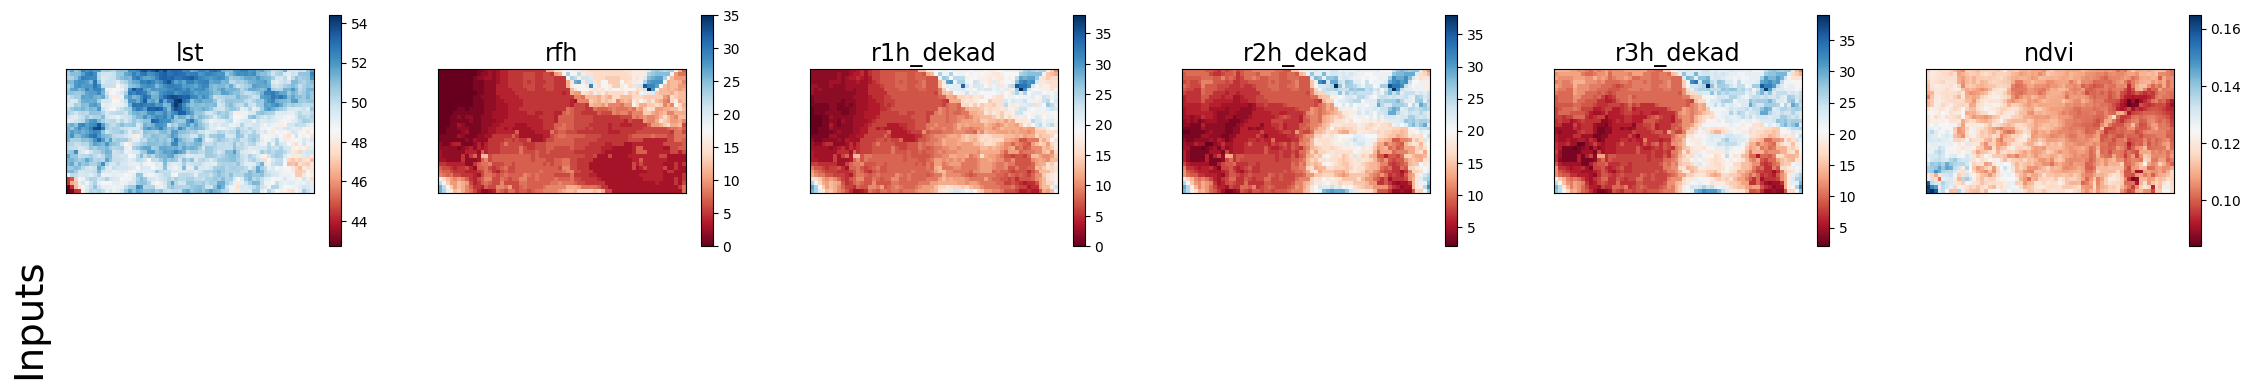

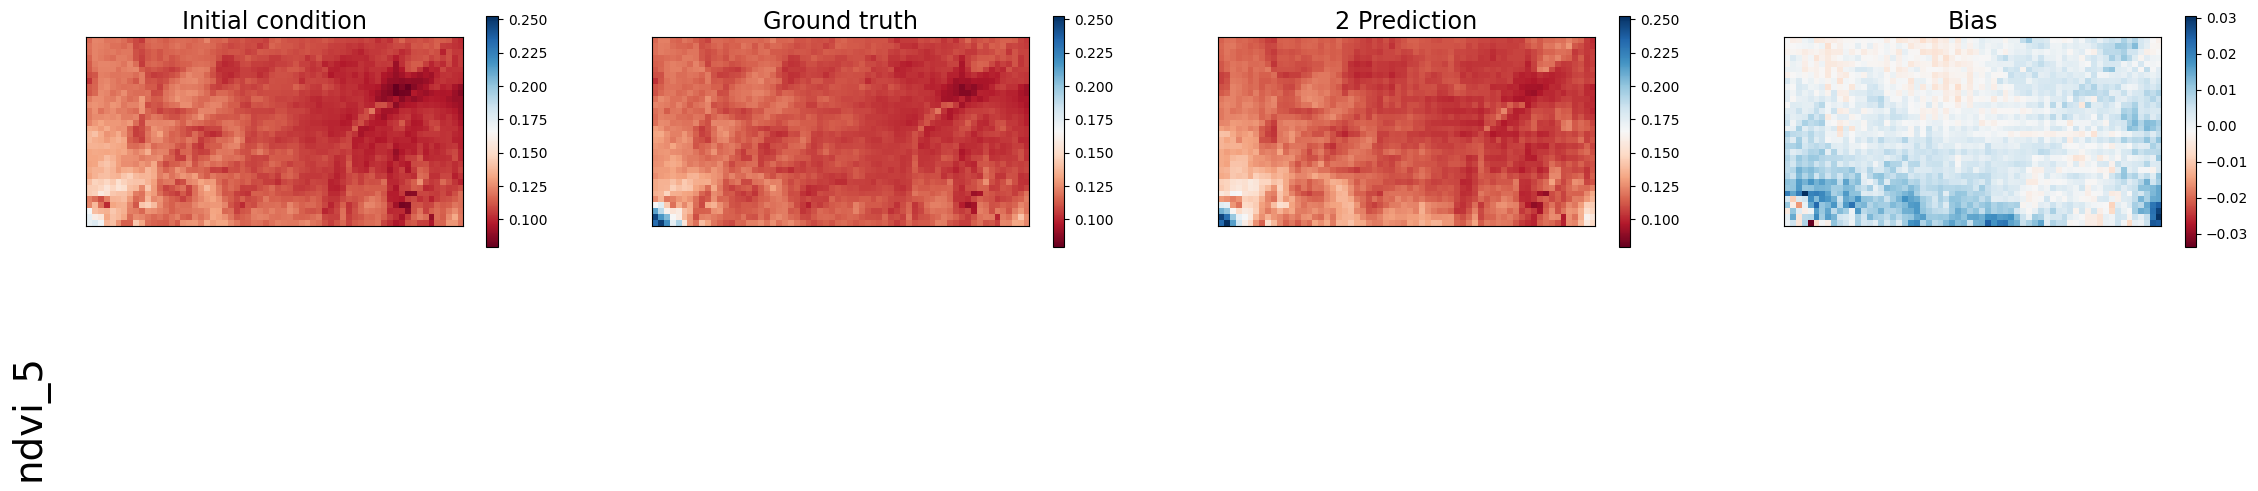

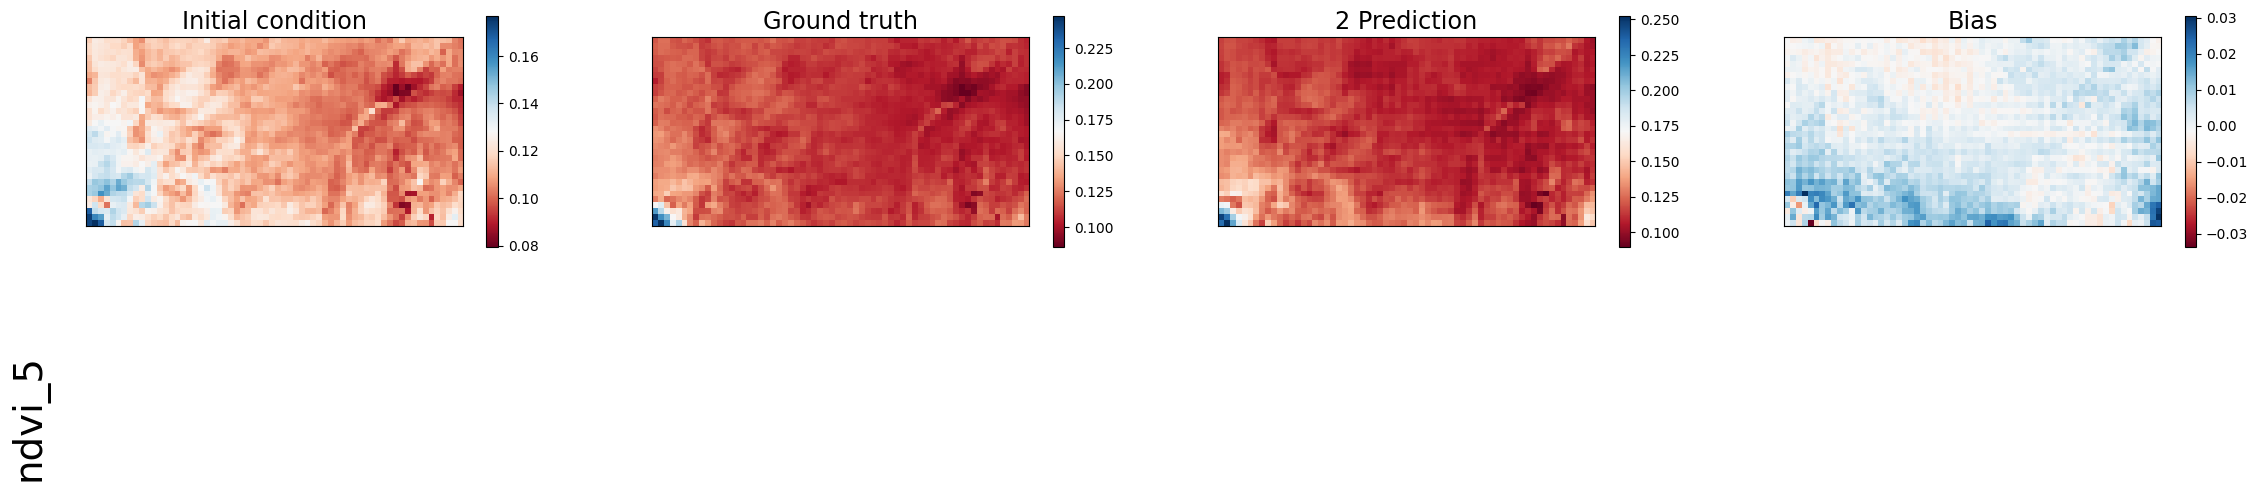

In [13]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 5, data_path="Data/CHIRPS_MODIS/data_npz/test/2021_3.npz")

**We give as input a random batch**

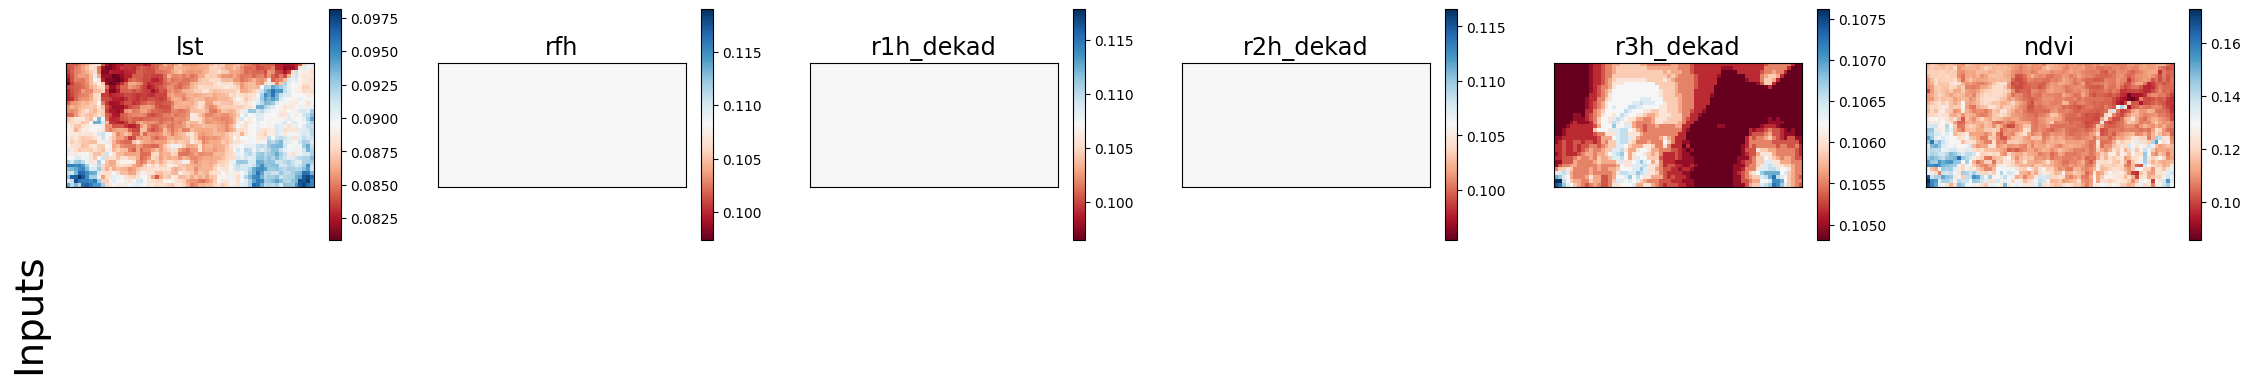

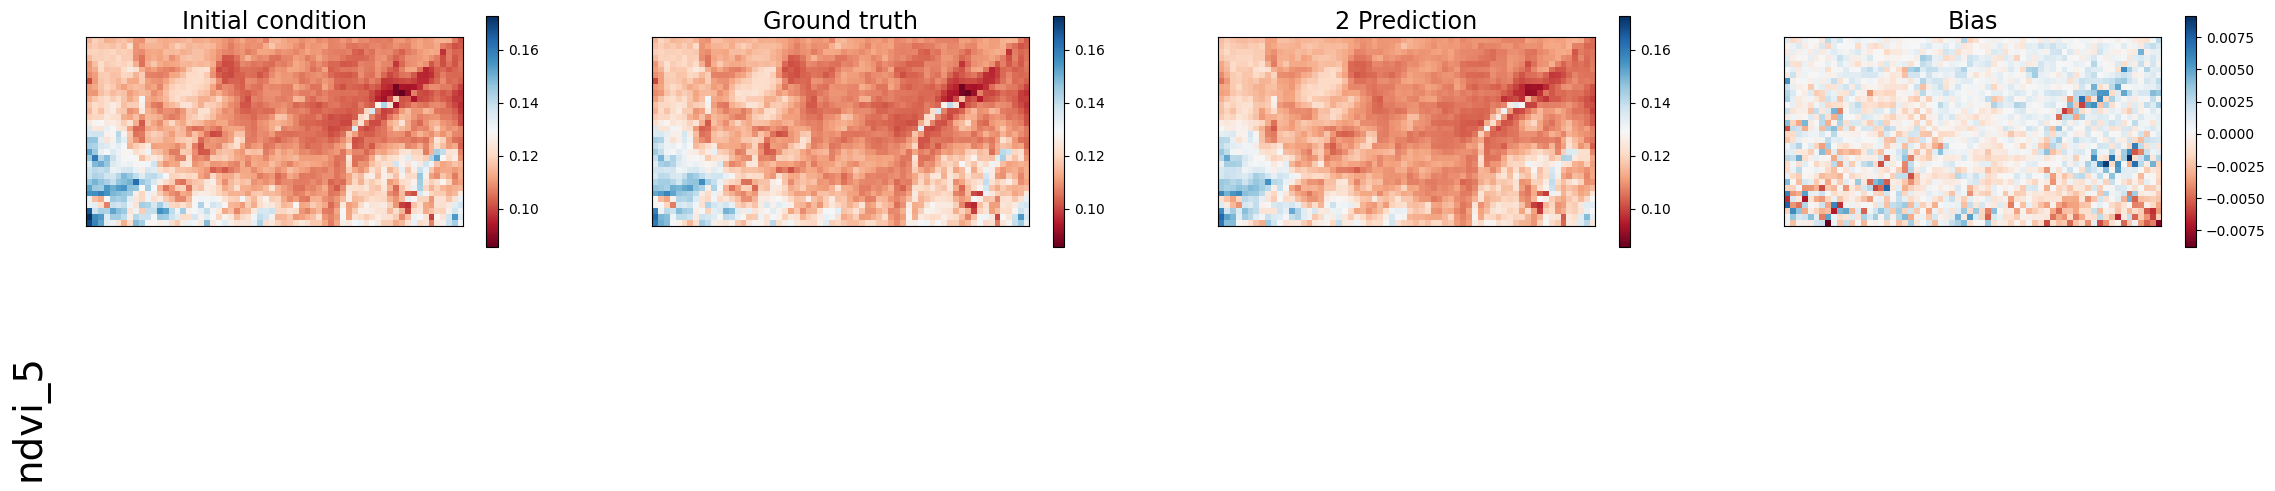

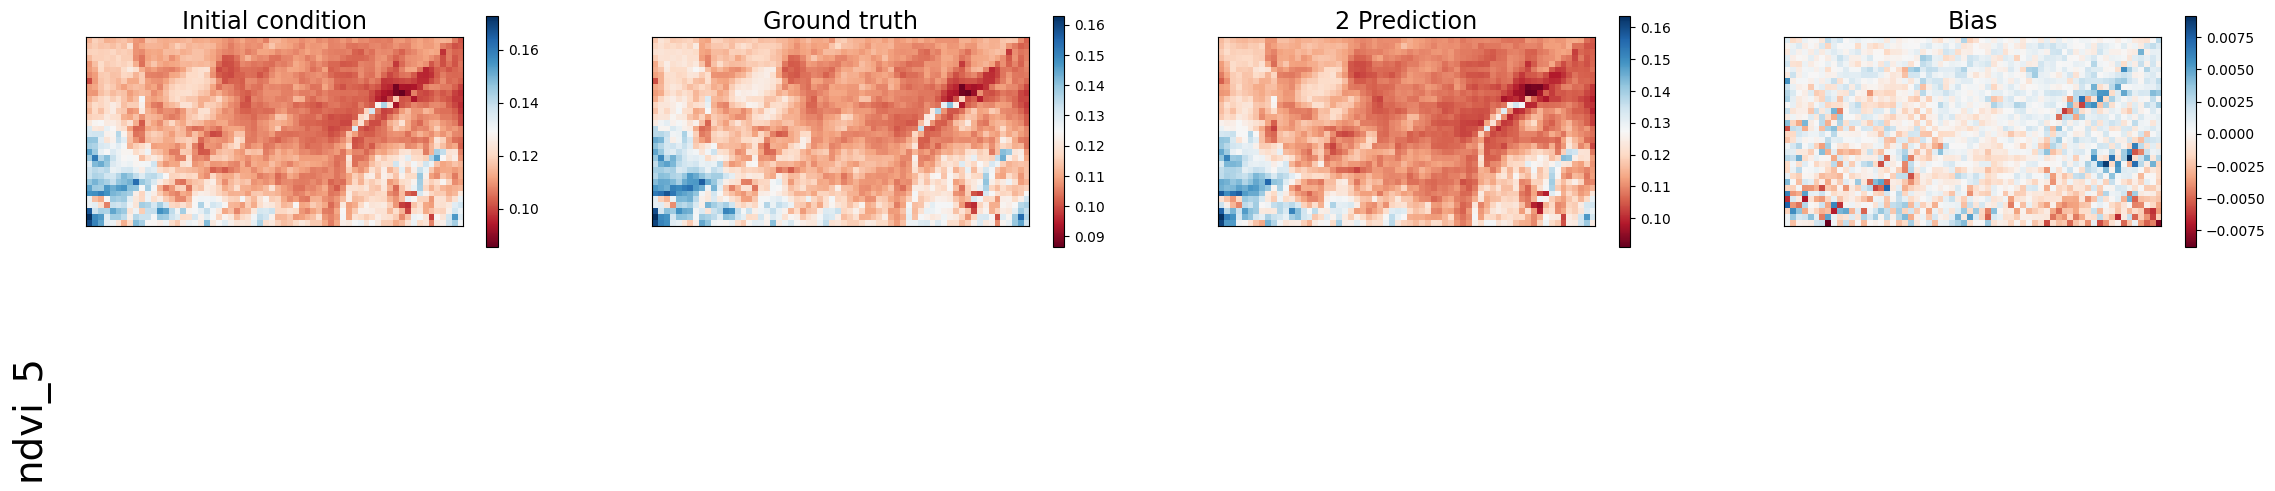

In [14]:
visualize_forecast(model, datamodule,mean_norm, std_norm, pred_range, var_name = var, var_id = 5, data_path=None)

        data_one_dekad =  torch.cat((lst_5_tensor,rfh_tensor,r1h_dekad_tensor, r2h_dekad_tensor, r3h_dekad_tensor ,ndvi_5_tensor), dim=1)
# Downscaling

In [2]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F

from climax.downscale.datamodule import DownscaleDataModule
from climax.downscale.module import DownscaleModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX

TASK_TO_RANGE = {
    '0 days' : 0,
    '10 days' : 1,
    '40 days': 4,
    '50 days': 5,
    '60 days': 6,
    '20 days': 2,
    '30 days': 3,
}